## **v1**

In [6]:
# For drive access
from google.colab import drive
drive.mount('/content/drive')

# Standard libraries
import numpy as np
import pandas as pd

# for loading the pickle files with features and labels
import pickle

# For audio
from IPython.display import Audio
import librosa

# For modeling
import tensorflow as tf
from sklearn.metrics import classification_report

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

Mounted at /content/drive


In [16]:
import pickle
import pandas as pd

file_path = 'drive/MyDrive/SYDE 577/BirdClef Models/data/features_mfcc_chroma.pkl'

try:
    with open(file_path, 'rb') as f:
        data = pickle.load(f)

    print(f"Successfully loaded data of type: {type(data)}")
    print("\nFirst few 'features' or content of the loaded data:")

    # Attempt to display as a DataFrame if applicable, otherwise print directly
    if isinstance(data, pd.DataFrame):
        display(data.head())
    elif isinstance(data, pd.Series):
        display(data.head())
    elif isinstance(data, dict) or isinstance(data, list):
        # For large dict/list, display first few items
        if len(data) > 5:
            if isinstance(data, dict):
                display({k: data[k] for i, k in enumerate(data) if i < 5})
            else:
                display(data[:5])
        else:
            display(data)
    else:
        display(data)

except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found. Please ensure it's in the same folder as this notebook or provide the correct path.")
except Exception as e:
    print(f"An error occurred while loading or displaying the file: {e}")

Successfully loaded data of type: <class 'dict'>

First few 'features' or content of the loaded data:


{'feature_type': 'mfcc_chroma',
 'version': 1,
 'feature_names': ['mfcc_chroma'],
 'target_name': 'primary_label',
 'X': array([array([[-298.89633   ,  110.72157   ,   22.57536   , ...,    0.6758952 ,
                   0.7843002 ,    0.87951   ],
               [-283.80026   ,  111.884964  ,   34.460964  , ...,    0.55334693,
                   0.52678627,    0.6569886 ],
               [-281.70108   ,  116.020584  ,   37.547836  , ...,    0.6608439 ,
                   0.7175045 ,    0.8827141 ],
               ...,
               [-290.16473   ,  109.97747   ,   28.832586  , ...,    1.        ,
                   0.8182714 ,    0.61985266],
               [-286.9269    ,  112.594574  ,   28.472038  , ...,    0.7935908 ,
                   0.6775403 ,    0.49586374],
               [-297.4353    ,  111.32239   ,   31.665718  , ...,    0.7919529 ,
                   0.6803034 ,    0.5268815 ]], dtype=float32)                  ,
        array([[-2.6564087e+02,  4.2033310e+01, -7.648605

In [17]:
print(type(data["X"]))
print(len(data["X"]))
print(data["X"][0].shape)


<class 'numpy.ndarray'>
4727
(938, 32)


In [18]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Pad/truncate sequences
max_len = 938  # choose based on longest sequence or desired length
X = pad_sequences(X, maxlen=max_len, dtype='float32', padding='post', truncating='post')
# Now X_padded.shape = (num_samples, max_len, 32)
X.shape

(4727, 938, 32)

In [19]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_int = le.fit_transform(y)     # maps strings → integers 0..C-1
print(np.unique(y_int), y_int.dtype)


[0 1 2 3 4 5 6 7 8 9] int64


In [20]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_int = le.fit_transform(y)   # y is your string label array
num_classes = len(le.classes_)
X_input = X     # Keep as (4727, 938, 65)



In [21]:
num_classes = len(np.unique(y_int))
print(num_classes)


10


In [22]:
def build_model(audio_features,
                learning_rate=0.001):

  tf.keras.backend.clear_session()

  # set audio features input layer
  inputs = tf.keras.layers.Input(shape=(max_len, 32))


  # add first convolution layer to the model
  features = tf.keras.layers.Conv1D(
              filters=32,
              kernel_size=5,
              strides=1,
              padding='same',
              data_format='channels_last',
              name='conv_1',
              activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(0.01))(inputs)

  # add first max pooling layer
  features = tf.keras.layers.MaxPool1D(pool_size=2, name='pool_1')(features)

  # add second convolution layer to the model
  features = tf.keras.layers.Conv1D(
              filters=64,
              kernel_size=5,
              strides=1,
              padding='same',
              name='conv_2',
              activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(0.01))(features)

  # add second max pooling layer
  features = tf.keras.layers.MaxPool1D(pool_size=2, name='pool_2')(features)

  # add a fully connected layer (need to flatten the output of the previous layers first)
  features = tf.keras.layers.Flatten()(features)

  features = tf.keras.layers.Dense(
      units=1024,
      name='fc_1',
      activation='relu')(features)

  # add dropout layer
  features = tf.keras.layers.Dropout(rate=0.5)(features)

  # add the last fully connected layer
  # this last layer sets the activation function to "None" in order to output the logits
  # note that passing activation = "softmax" will return class memembership probabilities but
  # in TensorFlow logits are prefered for numerical stability
  # set units=3 to get a 3 output unit (remember it's 3 species)
  outputs = tf.keras.layers.Dense(
      units=num_classes,
      name='fc_2',
      activation=None)(features)

  # build model and print summary
  model = tf.keras.Model(inputs=[inputs],
                          outputs=outputs,
                          name='Birds')

  print(model.summary())

  # compile model
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #set from_logits=True because our last layer does not apply softmax
              metrics=['accuracy'],
              weighted_metrics=['accuracy'])

  return model

### split

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X_input, y_int, test_size=0.3, random_state=42, stratify=y_int
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(X_train.shape, X_val.shape, X_test.shape)


(3308, 938, 32) (709, 938, 32) (710, 938, 32)


In [24]:
model = build_model(X_input, learning_rate=0.001)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32
)



Model: "Birds"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 938, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv1D)                 │ (None, 938, 32)        │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling1D)           │ (None, 469, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv1D)                 │ (None, 469, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling1D)           │ (None, 234, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_1 (Dense)                    │ (None, 1024)           │    15,336,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_2 (Dense)                    │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,362,154 (58.60 MB)

 Trainable params: 15,362,154 (58.60 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 28s 252ms/step - accuracy: 0.1198 - loss: 145.7499 - weighted_accuracy: 0.1198 - val_accuracy: 0.2073 - val_loss: 2.9065 - val_weighted_accuracy: 0.2073
Epoch 2/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 26s 252ms/step - accuracy: 0.3129 - loss: 2.5660 - weighted_accuracy: 0.3129 - val_accuracy: 0.2045 - val_loss: 2.8239 - val_weighted_accuracy: 0.2045
Epoch 3/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 41s 248ms/step - accuracy: 0.4378 - loss: 2.1918 - weighted_accuracy: 0.4378 - val_accuracy: 0.2567 - val_loss: 2.8211 - val_weighted_accuracy: 0.2567
Epoch 4/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 26s 246ms/step - accuracy: 0.5213 - loss: 1.9139 - weighted_accuracy: 0.5213 - val_accuracy: 0.2341 - val_loss: 2.9928 - val_weighted_accuracy: 0.2341
Epoch 5/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 25s 236ms/step - accuracy: 0.5638 - loss: 1.8308 - weighted_accuracy: 0.5638 - val_accuracy: 0.2553 - val_loss: 3.0257 - val_weighted_accuracy: 0.2553
Epoch 6/50
104/104 ━━━━━━━━━━━━━━━━━━━

In [25]:
results = model.evaluate(X_test, y_test)
test_loss = results[0]
test_acc = results[1]
test_weighted_acc = results[2]  # or just ignore duplicates
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)
print("Test weighted accuracy:", test_weighted_acc)



23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.3769 - loss: 5.3713 - weighted_accuracy: 0.3769
Test loss: 5.530724048614502
Test accuracy: 0.3704225420951843
Test weighted accuracy: 0.3704225420951843


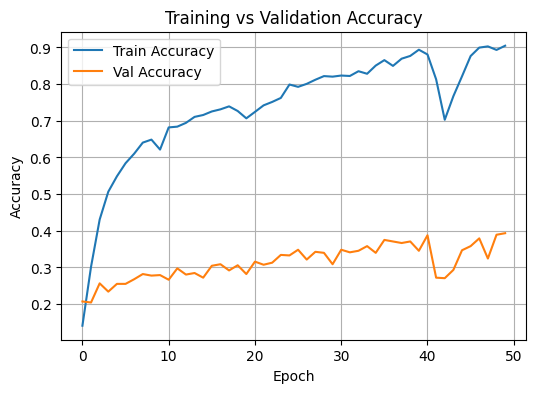

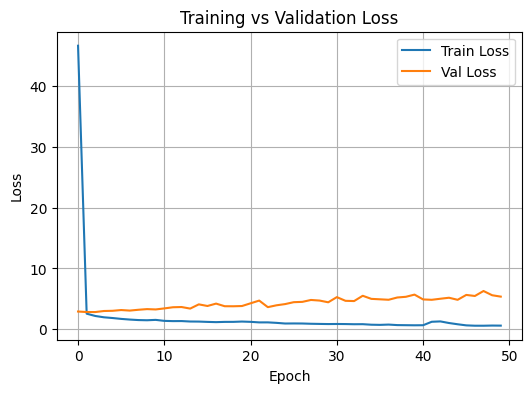

In [26]:
import matplotlib.pyplot as plt

# --- Accuracy Curve ---
plt.figure(figsize=(6,4))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# --- Loss Curve ---
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# y_test: true labels
# y_pred: model predictions (as class indices)

report = classification_report(y_test, y_pred, output_dict=True)

classes = list(report.keys())[:-3]   # removes accuracy/macro/micro entries
accuracies = [report[c]['precision'] for c in classes]  # or 'recall'

plt.figure(figsize=(8,4))
plt.bar(classes, accuracies)
plt.ylabel("Per-class Accuracy")
plt.xlabel("Class")
plt.title("Per-Class Accuracy")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


NameError: name 'y_pred' is not defined

In [ ]:
y_prob = model.predict(X_test)
y_pred = np.argmax(y_prob, axis=1)
y_true = y_test
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(cm))
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()



## v2

Loaded: drive/MyDrive/SYDE 577/BirdClef Models/data/features_mfcc_chroma.pkl
Raw X length: 4727 Raw y length: 4727
None entries in X: 0
Example sequence shapes (first 5): [(938, 32), (938, 32), (578, 32), (551, 32), (385, 32)]
Feature dimension per frame (should be 32): 32
X_padded shape: (4727, 938, 32)
Num classes: 10 Classes: ['barswa' 'cohmar1' 'combuz1' 'comsan' 'eaywag1' 'eubeat1' 'hoopoe'
 'thrnig1' 'wlwwar' 'woosan']
Shapes: train (3308, 938, 32) val (709, 938, 32) test (710, 938, 32)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 938, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 938, 32)        │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 469, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 469, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 234, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    15,336,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,362,154 (58.60 MB)

 Trainable params: 15,362,154 (58.60 MB)

 Non-trainable params: 0 (0.00 B)

Class weights: {0: np.float64(0.9560693641618497), 1: np.float64(1.1290102389078498), 2: np.float64(0.9963855421686747), 3: np.float64(0.9505747126436782), 4: np.float64(0.9505747126436782), 5: np.float64(1.0917491749174917), 6: np.float64(1.0917491749174917), 7: np.float64(0.9478510028653295), 8: np.float64(0.9533141210374639), 9: np.float64(0.975811209439528)}
Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.49224, saving model to best_1dcnn_mfcc_chroma.h5


104/104 - 50s - 482ms/step - accuracy: 0.3093 - loss: 3.1418 - val_accuracy: 0.4922 - val_loss: 2.3704
Epoch 2/50

Epoch 2: val_accuracy improved from 0.49224 to 0.55712, saving model to best_1dcnn_mfcc_chroma.h5


104/104 - 45s - 434ms/step - accuracy: 0.5837 - loss: 2.0168 - val_accuracy: 0.5571 - val_loss: 2.0311
Epoch 3/50

Epoch 3: val_accuracy improved from 0.55712 to 0.62906, saving model to best_1dcnn_mfcc_chroma.h5


104/104 - 81s - 783ms/step - accuracy: 0.7310 - loss: 1.4558 - val_accuracy: 0.6291 - val_loss: 1.8190
Epoch 4/50

Epoch 4: val_accuracy improved from 0.62906 to 0.63893, saving model to best_1dcnn_mfcc_chroma.h5


104/104 - 82s - 787ms/step - accuracy: 0.8359 - loss: 1.1045 - val_accuracy: 0.6389 - val_loss: 1.8468
Epoch 5/50

Epoch 5: val_accuracy did not improve from 0.63893
104/104 - 43s - 416ms/step - accuracy: 0.9042 - loss: 0.8383 - val_accuracy: 0.6333 - val_loss: 1.9251
Epoch 6/50

Epoch 6: val_accuracy did not improve from 0.63893
104/104 - 44s - 424ms/step - accuracy: 0.9368 - loss: 0.7222 - val_accuracy: 0.6389 - val_loss: 2.1397
Epoch 7/50

Epoch 7: val_accuracy did not improve from 0.63893
104/104 - 45s - 434ms/step - accuracy: 0.9592 - loss: 0.5909 - val_accuracy: 0.6375 - val_loss: 1.9499
Epoch 8/50

Epoch 8: val_accuracy did not improve from 0.63893
104/104 - 79s - 761ms/step - accuracy: 0.9616 - loss: 0.5532 - val_accuracy: 0.6276 - val_loss: 2.1141
Epoch 9/50

Epoch 9: val_accuracy improved from 0.63893 to 0.64175, saving model to best_1dcnn_mfcc_chroma.h5


104/104 - 43s - 417ms/step - accuracy: 0.9825 - loss: 0.4577 - val_accuracy: 0.6417 - val_loss: 2.0730
Epoch 10/50

Epoch 10: val_accuracy did not improve from 0.64175
104/104 - 81s - 779ms/step - accuracy: 0.9767 - loss: 0.4422 - val_accuracy: 0.6220 - val_loss: 1.9609
Epoch 11/50

Epoch 11: val_accuracy did not improve from 0.64175
104/104 - 83s - 795ms/step - accuracy: 0.9788 - loss: 0.4201 - val_accuracy: 0.6319 - val_loss: 2.0072
Epoch 12/50

Epoch 12: val_accuracy did not improve from 0.64175
104/104 - 43s - 412ms/step - accuracy: 0.9837 - loss: 0.3715 - val_accuracy: 0.6291 - val_loss: 2.0016
Epoch 13/50

Epoch 13: val_accuracy did not improve from 0.64175
104/104 - 84s - 811ms/step - accuracy: 0.9843 - loss: 0.3434 - val_accuracy: 0.6192 - val_loss: 2.0969
Epoch 14/50

Epoch 14: val_accuracy did not improve from 0.64175
104/104 - 46s - 439ms/step - accuracy: 0.9740 - loss: 0.3708 - val_accuracy: 0.6121 - val_loss: 1.8717
Epoch 15/50

Epoch 15: val_accuracy did not improve from 

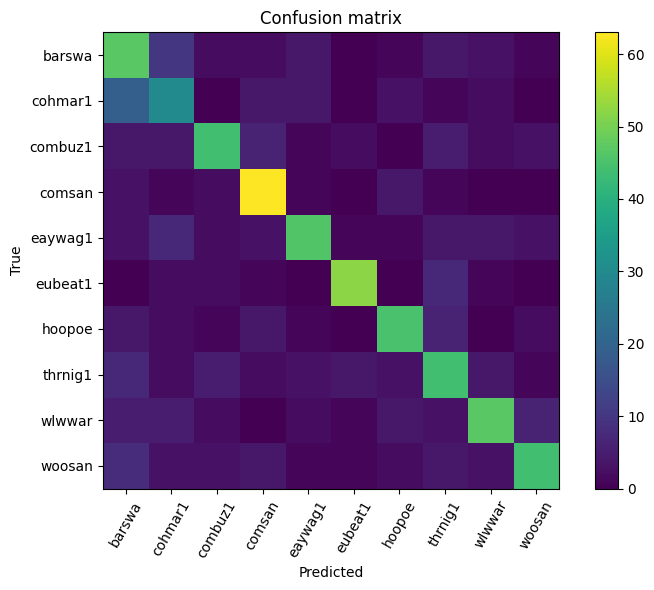

In [3]:
"""
Train a 1D-CNN on MFCC+Chroma features saved in features_mfcc_chroma.pkl
Adapt paths / MAX_LEN / hyperparams as needed.
"""

import os
import pickle
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences

# ----------------------- USER CONFIG -----------------------
PKL_PATH ='drive/MyDrive/SYDE 577/BirdClef Models/data/features_mfcc_chroma.pkl'  # adjust if needed
MAX_LEN = 938              # pad/truncate to this many frames (was used earlier)
BATCH_SIZE = 32
EPOCHS = 50
RANDOM_STATE = 42
MODEL_SAVE = "best_1dcnn_mfcc_chroma.h5"
# -----------------------------------------------------------

# --- load pickle ---
with open(PKL_PATH, "rb") as f:
    cache = pickle.load(f)

# cache expected keys: "X", "y" (X is object array of (T,32) arrays)
X_raw = cache["X"]
y_raw = np.array(cache["y"])

print("Loaded:", PKL_PATH)
print("Raw X length:", len(X_raw), "Raw y length:", len(y_raw))
print("None entries in X:", sum(1 for x in X_raw if x is None))

# --- filter out None entries ---
valid_idx = [i for i, x in enumerate(X_raw) if x is not None]
if len(valid_idx) != len(X_raw):
    print(f"Filtering out {len(X_raw)-len(valid_idx)} failed extractions.")
    X_raw = [X_raw[i] for i in valid_idx]
    y_raw = y_raw[valid_idx]

# --- quick sanity: show first few shapes and example file lengths ---
print("Example sequence shapes (first 5):", [x.shape for x in X_raw[:5]])
print("Feature dimension per frame (should be 32):", X_raw[0].shape[1])

# --- pad/truncate sequences to MAX_LEN ---
# X_raw is list of (T, feat_dim) arrays
feat_dim = X_raw[0].shape[1]
# Convert to list of 2D arrays then pad along time axis by flattening per-frame features
# pad_sequences expects 2D sequences of scalars; we will pad per-frame by creating list of (T, feat_dim)
# we'll achieve padding by creating an array of shape (N, MAX_LEN, feat_dim)
def pad_to_maxlen(X_list, max_len, feat_dim):
    N = len(X_list)
    out = np.zeros((N, max_len, feat_dim), dtype=np.float32)
    lengths = []
    for i, arr in enumerate(X_list):
        L = min(len(arr), max_len)
        out[i, :L, :] = arr[:L, :]
        lengths.append(L)
    return out, np.array(lengths, dtype=np.int32)

X_padded, lengths = pad_to_maxlen(X_raw, MAX_LEN, feat_dim)
print("X_padded shape:", X_padded.shape)

# --- label encode ---
le = LabelEncoder()
y = le.fit_transform(y_raw)
num_classes = len(le.classes_)
print("Num classes:", num_classes, "Classes:", le.classes_)

# --- split ---
X_train, X_temp, y_train, y_temp = train_test_split(
    X_padded, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=RANDOM_STATE, stratify=y_temp
)
print("Shapes: train", X_train.shape, "val", X_val.shape, "test", X_test.shape)

# --- normalize per feature using training set stats (mean/std over time and samples) ---
# compute mean/std over axes (samples, time) -> result shape (feat_dim,)
train_flat = X_train.reshape(-1, feat_dim)  # (N_train * MAX_LEN, feat_dim)
mu = train_flat.mean(axis=0)
sigma = train_flat.std(axis=0) + 1e-9
# apply
def normalize(X, mu, sigma):
    return (X - mu.reshape(1, 1, -1)) / sigma.reshape(1, 1, -1)

X_train = normalize(X_train, mu, sigma)
X_val = normalize(X_val, mu, sigma)
X_test = normalize(X_test, mu, sigma)

# --- build model ---
def build_1dcnn(input_shape, num_classes, lr=1e-3, l2=0.01):
    tf.keras.backend.clear_session()
    inputs = tf.keras.layers.Input(shape=input_shape)  # (MAX_LEN, feat_dim)
    x = tf.keras.layers.Conv1D(32, kernel_size=5, padding="same", activation="relu",
                               kernel_regularizer=tf.keras.regularizers.l2(l2))(inputs)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.Conv1D(64, kernel_size=5, padding="same", activation="relu",
                               kernel_regularizer=tf.keras.regularizers.l2(l2))(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=["accuracy"])
    return model

model = build_1dcnn((MAX_LEN, feat_dim), num_classes)
model.summary()

# --- callbacks ---
callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=8, restore_best_weights=True),
    ModelCheckpoint(MODEL_SAVE, monitor="val_accuracy", save_best_only=True, verbose=1)
]

# --- class weights (optional, helps imbalance) ---
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weights = {i: w for i, w in enumerate(class_weights)}
print("Class weights:", class_weights)

# --- train ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=2
)

# --- evaluate ---
print("Evaluate on test set:")
results = model.evaluate(X_test, y_test, verbose=0)
print("Test loss, acc:", results)

# --- predictions & reports ---
y_prob = model.predict(X_test, batch_size=BATCH_SIZE, verbose=0)
y_pred = np.argmax(y_prob, axis=1)
print("\nClassification report (test):")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(le.classes_))
plt.xticks(tick_marks, le.classes_, rotation=60)
plt.yticks(tick_marks, le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


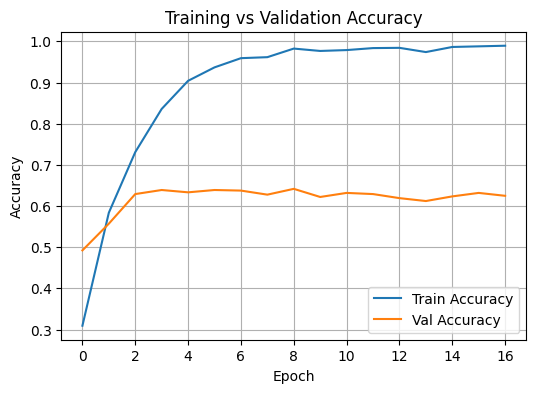

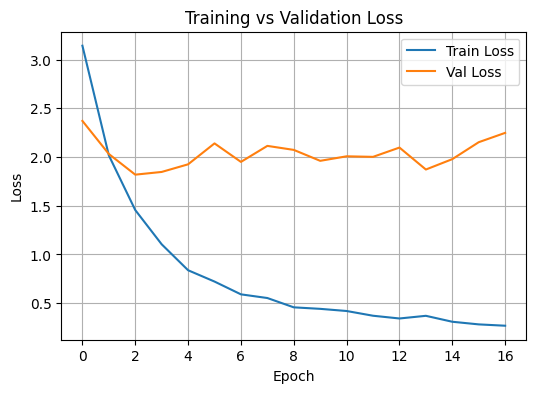

In [5]:
import matplotlib.pyplot as plt

# --- Accuracy Curve ---
plt.figure(figsize=(6,4))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# --- Loss Curve ---
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

## v3

In [6]:
"""
Improved 1D-CNN for BirdCLEF 2024 with Data Augmentation
Uses existing MFCC+Chroma features from features_mfcc_chroma.pkl
"""

import os
import pickle
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# ----------------------- CONFIG -----------------------
PKL_PATH = 'drive/MyDrive/SYDE 577/BirdClef Models/data/features_mfcc_chroma.pkl'
MAX_LEN = 938
BATCH_SIZE = 32
EPOCHS = 100
RANDOM_STATE = 42
MODEL_SAVE = "best_1dcnn_improved.h5"
# ------------------------------------------------------

# ==================== DATA AUGMENTATION ====================
class AudioAugmenter:
    def __init__(self, time_mask_prob=0.3, freq_mask_prob=0.3,
                 noise_prob=0.2, shift_prob=0.3):
        self.time_mask_prob = time_mask_prob
        self.freq_mask_prob = freq_mask_prob
        self.noise_prob = noise_prob
        self.shift_prob = shift_prob

    def time_mask(self, x, mask_size=20):
        x = x.copy()
        t = x.shape[0]
        if t <= mask_size:
            return x
        t0 = np.random.randint(0, t - mask_size)
        x[t0:t0+mask_size, :] = 0
        return x

    def freq_mask(self, x, mask_size=5):
        x = x.copy()
        f = x.shape[1]
        if f <= mask_size:
            return x
        f0 = np.random.randint(0, f - mask_size)
        x[:, f0:f0+mask_size] = 0
        return x

    def add_noise(self, x, noise_factor=0.005):
        noise = np.random.randn(*x.shape) * noise_factor
        return x + noise

    def time_shift(self, x, shift_max=50):
        shift = np.random.randint(-shift_max, shift_max)
        return np.roll(x, shift, axis=0)

    def augment(self, x):
        if np.random.rand() < self.time_mask_prob:
            x = self.time_mask(x)
        if np.random.rand() < self.freq_mask_prob:
            x = self.freq_mask(x)
        if np.random.rand() < self.noise_prob:
            x = self.add_noise(x)
        if np.random.rand() < self.shift_prob:
            x = self.time_shift(x)
        return x


class AugmentedGenerator(tf.keras.utils.Sequence):
    def __init__(self, X, y, batch_size, augmenter=None, shuffle=True):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.augmenter = augmenter
        self.shuffle = shuffle
        self.indices = np.arange(len(X))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        X_batch = self.X[batch_indices].copy()
        y_batch = self.y[batch_indices]

        if self.augmenter is not None:
            for i in range(len(X_batch)):
                X_batch[i] = self.augmenter.augment(X_batch[i])

        return X_batch, y_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# ==================== LOAD DATA ====================
print("Loading data...")
with open(PKL_PATH, "rb") as f:
    cache = pickle.load(f)

X_raw = cache["X"]
y_raw = np.array(cache["y"])

print(f"Loaded: {PKL_PATH}")
print(f"Raw X length: {len(X_raw)}, Raw y length: {len(y_raw)}")

# Filter out None entries
valid_idx = [i for i, x in enumerate(X_raw) if x is not None]
if len(valid_idx) != len(X_raw):
    print(f"Filtering out {len(X_raw)-len(valid_idx)} failed extractions.")
    X_raw = [X_raw[i] for i in valid_idx]
    y_raw = y_raw[valid_idx]

print(f"Valid samples: {len(X_raw)}")
print(f"Feature dimension: {X_raw[0].shape[1]}")

# ==================== PREPROCESSING ====================
def pad_to_maxlen(X_list, max_len, feat_dim):
    N = len(X_list)
    out = np.zeros((N, max_len, feat_dim), dtype=np.float32)
    for i, arr in enumerate(X_list):
        L = min(len(arr), max_len)
        out[i, :L, :] = arr[:L, :]
    return out

feat_dim = X_raw[0].shape[1]
X_padded = pad_to_maxlen(X_raw, MAX_LEN, feat_dim)
print(f"X_padded shape: {X_padded.shape}")

# Label encoding
le = LabelEncoder()
y = le.fit_transform(y_raw)
num_classes = len(le.classes_)
print(f"Number of classes: {num_classes}")
print(f"Classes: {le.classes_}")

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(
    X_padded, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=RANDOM_STATE, stratify=y_temp
)
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# Normalize using training statistics
train_flat = X_train.reshape(-1, feat_dim)
mu = train_flat.mean(axis=0)
sigma = train_flat.std(axis=0) + 1e-9

X_train = (X_train - mu.reshape(1, 1, -1)) / sigma.reshape(1, 1, -1)
X_val = (X_val - mu.reshape(1, 1, -1)) / sigma.reshape(1, 1, -1)
X_test = (X_test - mu.reshape(1, 1, -1)) / sigma.reshape(1, 1, -1)

# ==================== MODEL ====================
def build_improved_1dcnn(input_shape, num_classes, lr=1e-3, l2=0.001):
    tf.keras.backend.clear_session()
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Block 1
    x = tf.keras.layers.Conv1D(64, kernel_size=7, padding="same",
                               kernel_regularizer=tf.keras.regularizers.l2(l2))(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    # Block 2
    x = tf.keras.layers.Conv1D(128, kernel_size=5, padding="same",
                               kernel_regularizer=tf.keras.regularizers.l2(l2))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    # Block 3
    x = tf.keras.layers.Conv1D(256, kernel_size=3, padding="same",
                               kernel_regularizer=tf.keras.regularizers.l2(l2))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    # Block 4
    x = tf.keras.layers.Conv1D(256, kernel_size=3, padding="same",
                               kernel_regularizer=tf.keras.regularizers.l2(l2))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.GlobalMaxPooling1D()(x)

    # Dense layers
    x = tf.keras.layers.Dense(512, activation="relu",
                             kernel_regularizer=tf.keras.regularizers.l2(l2))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Dense(256, activation="relu",
                             kernel_regularizer=tf.keras.regularizers.l2(l2))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs)

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=lr,
        decay_steps=1000,
        decay_rate=0.9
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=["accuracy"]
    )
    return model

print("\nBuilding model...")
model = build_improved_1dcnn((MAX_LEN, feat_dim), num_classes, lr=1e-3, l2=0.001)
model.summary()

# ==================== TRAINING ====================
# Callbacks
callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1),
    ModelCheckpoint(MODEL_SAVE, monitor="val_accuracy", save_best_only=True, verbose=1)
]

# Class weights for imbalance
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weights = {i: w for i, w in enumerate(class_weights)}
print(f"\nClass weights computed: {len(class_weights)} classes")

# Data generators with augmentation
augmenter = AudioAugmenter()
train_gen = AugmentedGenerator(X_train, y_train, BATCH_SIZE, augmenter=augmenter)
val_gen = AugmentedGenerator(X_val, y_val, BATCH_SIZE, augmenter=None, shuffle=False)

print("\nStarting training...")
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=2
)

# ==================== EVALUATION ====================
print("\n" + "="*50)
print("Evaluating on test set...")
results = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f}")

# Predictions
y_prob = model.predict(X_test, batch_size=BATCH_SIZE, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix", fontsize=14)
plt.colorbar()
tick_marks = np.arange(len(le.classes_))
plt.xticks(tick_marks, le.classes_, rotation=60, ha='right')
plt.yticks(tick_marks, le.classes_)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Training history plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Val Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Val Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*50)
print(f"Model saved to: {MODEL_SAVE}")
print("Training complete!")

Loading data...
Loaded: drive/MyDrive/SYDE 577/BirdClef Models/data/features_mfcc_chroma.pkl
Raw X length: 4727, Raw y length: 4727
Valid samples: 4727
Feature dimension: 32
X_padded shape: (4727, 938, 32)
Number of classes: 10
Classes: ['barswa' 'cohmar1' 'combuz1' 'comsan' 'eaywag1' 'eubeat1' 'hoopoe'
 'thrnig1' 'wlwwar' 'woosan']
Train: (3308, 938, 32), Val: (709, 938, 32), Test: (710, 938, 32)

Building model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 938, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 938, 64)        │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 938, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 938, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 469, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 469, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 469, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 469, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 469, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 234, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 234, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 234, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 234, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 234, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 117, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 117, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 117, 256)       │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 117, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 117, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │             

 Total params: 622,282 (2.37 MB)

 Trainable params: 619,338 (2.36 MB)

 Non-trainable params: 2,944 (11.50 KB)


Class weights computed: 10 classes

Starting training...
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.38646, saving model to best_1dcnn_improved.h5


104/104 - 77s - 737ms/step - accuracy: 0.2739 - loss: 3.6028 - val_accuracy: 0.3865 - val_loss: 2.9287 - learning_rate: 9.8910e-04
Epoch 2/100

Epoch 2: val_accuracy improved from 0.38646 to 0.56417, saving model to best_1dcnn_improved.h5


104/104 - 55s - 530ms/step - accuracy: 0.4855 - loss: 2.7393 - val_accuracy: 0.5642 - val_loss: 2.4215 - learning_rate: 9.7832e-04
Epoch 3/100

Epoch 3: val_accuracy improved from 0.56417 to 0.66432, saving model to best_1dcnn_improved.h5


104/104 - 56s - 537ms/step - accuracy: 0.5565 - loss: 2.4590 - val_accuracy: 0.6643 - val_loss: 2.1038 - learning_rate: 9.6766e-04
Epoch 4/100

Epoch 4: val_accuracy improved from 0.66432 to 0.66573, saving model to best_1dcnn_improved.h5


104/104 - 55s - 533ms/step - accuracy: 0.6052 - loss: 2.2867 - val_accuracy: 0.6657 - val_loss: 2.0928 - learning_rate: 9.5712e-04
Epoch 5/100

Epoch 5: val_accuracy did not improve from 0.66573
104/104 - 57s - 547ms/step - accuracy: 0.6508 - loss: 2.1349 - val_accuracy: 0.6643 - val_loss: 2.0342 - learning_rate: 9.4669e-04
Epoch 6/100

Epoch 6: val_accuracy did not improve from 0.66573
104/104 - 55s - 524ms/step - accuracy: 0.6696 - loss: 2.0204 - val_accuracy: 0.6516 - val_loss: 2.0477 - learning_rate: 9.3637e-04
Epoch 7/100

Epoch 7: val_accuracy improved from 0.66573 to 0.74612, saving model to best_1dcnn_improved.h5


104/104 - 54s - 518ms/step - accuracy: 0.7095 - loss: 1.9112 - val_accuracy: 0.7461 - val_loss: 1.7799 - learning_rate: 9.2617e-04
Epoch 8/100

Epoch 8: val_accuracy improved from 0.74612 to 0.75882, saving model to best_1dcnn_improved.h5


104/104 - 55s - 532ms/step - accuracy: 0.7207 - loss: 1.8090 - val_accuracy: 0.7588 - val_loss: 1.6918 - learning_rate: 9.1607e-04
Epoch 9/100

Epoch 9: val_accuracy improved from 0.75882 to 0.76164, saving model to best_1dcnn_improved.h5


104/104 - 55s - 533ms/step - accuracy: 0.7421 - loss: 1.7491 - val_accuracy: 0.7616 - val_loss: 1.6421 - learning_rate: 9.0609e-04
Epoch 10/100

Epoch 10: val_accuracy did not improve from 0.76164
104/104 - 55s - 528ms/step - accuracy: 0.7545 - loss: 1.6722 - val_accuracy: 0.7560 - val_loss: 1.6390 - learning_rate: 8.9622e-04
Epoch 11/100

Epoch 11: val_accuracy improved from 0.76164 to 0.76728, saving model to best_1dcnn_improved.h5


104/104 - 70s - 673ms/step - accuracy: 0.7536 - loss: 1.6452 - val_accuracy: 0.7673 - val_loss: 1.6208 - learning_rate: 8.8645e-04
Epoch 12/100

Epoch 12: val_accuracy did not improve from 0.76728
104/104 - 59s - 564ms/step - accuracy: 0.7733 - loss: 1.5895 - val_accuracy: 0.7673 - val_loss: 1.5721 - learning_rate: 8.7679e-04
Epoch 13/100

Epoch 13: val_accuracy improved from 0.76728 to 0.77151, saving model to best_1dcnn_improved.h5


104/104 - 57s - 551ms/step - accuracy: 0.7881 - loss: 1.5177 - val_accuracy: 0.7715 - val_loss: 1.5696 - learning_rate: 8.6723e-04
Epoch 14/100

Epoch 14: val_accuracy did not improve from 0.77151
104/104 - 57s - 544ms/step - accuracy: 0.7811 - loss: 1.5086 - val_accuracy: 0.7715 - val_loss: 1.5179 - learning_rate: 8.5778e-04
Epoch 15/100

Epoch 15: val_accuracy improved from 0.77151 to 0.80395, saving model to best_1dcnn_improved.h5


104/104 - 56s - 537ms/step - accuracy: 0.7854 - loss: 1.4487 - val_accuracy: 0.8039 - val_loss: 1.3760 - learning_rate: 8.4843e-04
Epoch 16/100

Epoch 16: val_accuracy did not improve from 0.80395
104/104 - 54s - 518ms/step - accuracy: 0.7963 - loss: 1.4132 - val_accuracy: 0.7842 - val_loss: 1.4484 - learning_rate: 8.3919e-04
Epoch 17/100

Epoch 17: val_accuracy improved from 0.80395 to 0.81805, saving model to best_1dcnn_improved.h5


104/104 - 57s - 545ms/step - accuracy: 0.7996 - loss: 1.3783 - val_accuracy: 0.8181 - val_loss: 1.3225 - learning_rate: 8.3004e-04
Epoch 18/100

Epoch 18: val_accuracy did not improve from 0.81805
104/104 - 79s - 761ms/step - accuracy: 0.8129 - loss: 1.3129 - val_accuracy: 0.8181 - val_loss: 1.2734 - learning_rate: 8.2100e-04
Epoch 19/100

Epoch 19: val_accuracy did not improve from 0.81805
104/104 - 54s - 520ms/step - accuracy: 0.8096 - loss: 1.3138 - val_accuracy: 0.8068 - val_loss: 1.3389 - learning_rate: 8.1205e-04
Epoch 20/100

Epoch 20: val_accuracy improved from 0.81805 to 0.83498, saving model to best_1dcnn_improved.h5


104/104 - 56s - 534ms/step - accuracy: 0.8159 - loss: 1.2775 - val_accuracy: 0.8350 - val_loss: 1.2219 - learning_rate: 8.0320e-04
Epoch 21/100

Epoch 21: val_accuracy did not improve from 0.83498
104/104 - 55s - 529ms/step - accuracy: 0.8099 - loss: 1.2334 - val_accuracy: 0.8237 - val_loss: 1.2388 - learning_rate: 7.9445e-04
Epoch 22/100

Epoch 22: val_accuracy did not improve from 0.83498
104/104 - 55s - 531ms/step - accuracy: 0.8198 - loss: 1.2152 - val_accuracy: 0.8152 - val_loss: 1.1969 - learning_rate: 7.8579e-04
Epoch 23/100

Epoch 23: val_accuracy improved from 0.83498 to 0.84203, saving model to best_1dcnn_improved.h5


104/104 - 56s - 534ms/step - accuracy: 0.8259 - loss: 1.1834 - val_accuracy: 0.8420 - val_loss: 1.1554 - learning_rate: 7.7723e-04
Epoch 24/100

Epoch 24: val_accuracy did not improve from 0.84203
104/104 - 56s - 542ms/step - accuracy: 0.8277 - loss: 1.1779 - val_accuracy: 0.8166 - val_loss: 1.2276 - learning_rate: 7.6876e-04
Epoch 25/100

Epoch 25: val_accuracy did not improve from 0.84203
104/104 - 56s - 538ms/step - accuracy: 0.8349 - loss: 1.1322 - val_accuracy: 0.8124 - val_loss: 1.2307 - learning_rate: 7.6038e-04
Epoch 26/100

Epoch 26: val_accuracy did not improve from 0.84203
104/104 - 81s - 775ms/step - accuracy: 0.8331 - loss: 1.1498 - val_accuracy: 0.8322 - val_loss: 1.1274 - learning_rate: 7.5209e-04
Epoch 27/100

Epoch 27: val_accuracy did not improve from 0.84203
104/104 - 84s - 807ms/step - accuracy: 0.8443 - loss: 1.0873 - val_accuracy: 0.7969 - val_loss: 1.2197 - learning_rate: 7.4390e-04
Epoch 28/100

Epoch 28: val_accuracy did not improve from 0.84203
104/104 - 56s -

104/104 - 55s - 530ms/step - accuracy: 0.8525 - loss: 1.0221 - val_accuracy: 0.8491 - val_loss: 1.0469 - learning_rate: 7.1984e-04
Epoch 31/100

Epoch 31: val_accuracy did not improve from 0.84908
104/104 - 80s - 770ms/step - accuracy: 0.8640 - loss: 0.9677 - val_accuracy: 0.8068 - val_loss: 1.1400 - learning_rate: 7.1200e-04
Epoch 32/100

Epoch 32: val_accuracy did not improve from 0.84908
104/104 - 83s - 800ms/step - accuracy: 0.8531 - loss: 0.9971 - val_accuracy: 0.7927 - val_loss: 1.2025 - learning_rate: 7.0424e-04
Epoch 33/100

Epoch 33: val_accuracy did not improve from 0.84908
104/104 - 55s - 532ms/step - accuracy: 0.8489 - loss: 1.0073 - val_accuracy: 0.8350 - val_loss: 1.0874 - learning_rate: 6.9656e-04
Epoch 34/100

Epoch 34: val_accuracy did not improve from 0.84908
104/104 - 53s - 506ms/step - accuracy: 0.8570 - loss: 0.9566 - val_accuracy: 0.7814 - val_loss: 1.2568 - learning_rate: 6.8897e-04
Epoch 35/100

Epoch 35: val_accuracy did not improve from 0.84908
104/104 - 54s -

104/104 - 82s - 785ms/step - accuracy: 0.8609 - loss: 0.9354 - val_accuracy: 0.8660 - val_loss: 0.9556 - learning_rate: 6.7404e-04
Epoch 37/100

Epoch 37: val_accuracy did not improve from 0.86601
104/104 - 54s - 519ms/step - accuracy: 0.8730 - loss: 0.8858 - val_accuracy: 0.8025 - val_loss: 1.1147 - learning_rate: 6.6669e-04
Epoch 38/100

Epoch 38: val_accuracy did not improve from 0.86601
104/104 - 54s - 518ms/step - accuracy: 0.8661 - loss: 0.8911 - val_accuracy: 0.8505 - val_loss: 0.9772 - learning_rate: 6.5943e-04
Epoch 39/100

Epoch 39: val_accuracy did not improve from 0.86601
104/104 - 54s - 519ms/step - accuracy: 0.8739 - loss: 0.8755 - val_accuracy: 0.8392 - val_loss: 1.0000 - learning_rate: 6.5224e-04
Epoch 40/100

Epoch 40: val_accuracy did not improve from 0.86601
104/104 - 53s - 506ms/step - accuracy: 0.8664 - loss: 0.8854 - val_accuracy: 0.8251 - val_loss: 1.0580 - learning_rate: 6.4513e-04
Epoch 41/100


TypeError: This optimizer was created with a `LearningRateSchedule` object as its `learning_rate` constructor argument, hence its learning rate is not settable. If you need the learning rate to be settable, you should instantiate the optimizer with a float `learning_rate` argument.

In [13]:
"""
Quick test evaluation on saved best model
"""
import os
import pickle
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf

# ----------------------- CONFIG -----------------------
MODEL_PATH = "/content/drive/MyDrive/SYDE 577/BirdClef Models/best_1dcnn_improved.h5"
PKL_PATH = '/content/drive/MyDrive/SYDE 577/BirdClef Models/data/features_mfcc_chroma.pkl'
MAX_LEN = 938
RANDOM_STATE = 42
# ------------------------------------------------------

print("Loading model...")
print(f"Model: {MODEL_PATH}")
model = tf.keras.models.load_model(MODEL_PATH)
print("✓ Model loaded\n")

print("Loading data...")
with open(PKL_PATH, "rb") as f:
    cache = pickle.load(f)

X_raw = cache["X"]
y_raw = np.array(cache["y"])

# Filter None
valid_idx = [i for i, x in enumerate(X_raw) if x is not None]
X_raw = [X_raw[i] for i in valid_idx]
y_raw = y_raw[valid_idx]

# Pad
def pad_to_maxlen(X_list, max_len, feat_dim):
    N = len(X_list)
    out = np.zeros((N, max_len, feat_dim), dtype=np.float32)
    for i, arr in enumerate(X_list):
        L = min(len(arr), max_len)
        out[i, :L, :] = arr[:L, :]
    return out

feat_dim = X_raw[0].shape[1]
X_padded = pad_to_maxlen(X_raw, MAX_LEN, feat_dim)

# Labels
le = LabelEncoder()
y = le.fit_transform(y_raw)

# Same split as training
X_train, X_temp, y_train, y_temp = train_test_split(
    X_padded, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=RANDOM_STATE, stratify=y_temp
)

# Normalize with training stats
train_flat = X_train.reshape(-1, feat_dim)
mu = train_flat.mean(axis=0)
sigma = train_flat.std(axis=0) + 1e-9
X_test = (X_test - mu.reshape(1, 1, -1)) / sigma.reshape(1, 1, -1)

print(f"Test set shape: {X_test.shape}\n")

# Evaluate
print("="*60)
print("EVALUATING ON TEST SET")
print("="*60)

results = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f} ({results[1]*100:.2f}%)")

# Detailed predictions
y_prob = model.predict(X_test, batch_size=64, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test, y_pred, target_names=le.classes_))

print("\nDone!")

Loading model...
Model: /content/drive/MyDrive/SYDE 577/BirdClef Models/best_1dcnn_improved.h5
✓ Model loaded

Loading data...
Test set shape: (710, 938, 32)

EVALUATING ON TEST SET

Test Loss: 0.9628
Test Accuracy: 0.8479 (84.79%)

CLASSIFICATION REPORT
              precision    recall  f1-score   support

      barswa       0.66      0.70      0.68        74
     cohmar1       0.81      0.56      0.66        63
     combuz1       0.91      0.89      0.90        71
      comsan       0.84      0.93      0.89        75
     eaywag1       0.93      0.88      0.90        74
     eubeat1       0.88      0.98      0.93        65
      hoopoe       0.89      0.86      0.88        65
     thrnig1       0.94      0.88      0.91        75
      wlwwar       0.84      0.91      0.87        75
      woosan       0.80      0.86      0.83        73

    accuracy                           0.85       710
   macro avg       0.85      0.85      0.84       710
weighted avg       0.85      0.85      0.

### gpu

GPU Configuration
✓ Found 1 GPU(s)
  GPU Name: /physical_device:GPU:0
✓ Mixed precision enabled (float16)

Loading data...
Loaded: drive/MyDrive/SYDE 577/BirdClef Models/data/features_mfcc_chroma.pkl
Raw X length: 4727, Raw y length: 4727
Valid samples: 4727
Feature dimension: 32
X_padded shape: (4727, 938, 32)
Number of classes: 10
Classes: ['barswa' 'cohmar1' 'combuz1' 'comsan' 'eaywag1' 'eubeat1' 'hoopoe'
 'thrnig1' 'wlwwar' 'woosan']
Train: (3308, 938, 32), Val: (709, 938, 32), Test: (710, 938, 32)

Building model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 938, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 938, 64)        │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 938, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 938, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 469, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 469, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 469, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 469, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 469, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 234, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 234, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 234, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 234, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 234, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 117, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 117, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 117, 256)       │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 117, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 117, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │             

 Total params: 622,282 (2.37 MB)

 Trainable params: 619,338 (2.36 MB)

 Non-trainable params: 2,944 (11.50 KB)


Class weights computed: 10 classes

Starting training...
Training on: /physical_device:GPU:0
Batch size: 64
Steps per epoch: 52

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.1928 - loss: 4.0624
Epoch 1: val_accuracy improved from -inf to 0.48096, saving model to /drive/MyDrive/SYDE 577/BirdClef Models/best_1dcnn_improved.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 246ms/step - accuracy: 0.1941 - loss: 4.0543 - val_accuracy: 0.4810 - val_loss: 2.7528 - learning_rate: 0.0010
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4205 - loss: 2.9315
Epoch 2: val_accuracy improved from 0.48096 to 0.52327, saving model to /drive/MyDrive/SYDE 577/BirdClef Models/best_1dcnn_improved.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.4210 - loss: 2.9295 - val_accuracy: 0.5233 - val_loss: 2.5360 - learning_rate: 0.0010
Epoch 3/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5069 - loss: 2.6278
Epoch 3: val_accuracy improved from 0.52327 to 0.59803, saving model to /drive/MyDrive/SYDE 577/BirdClef Models/best_1dcnn_improved.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5077 - loss: 2.6245 - val_accuracy: 0.5980 - val_loss: 2.2516 - learning_rate: 0.0010
Epoch 4/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5786 - loss: 2.3376
Epoch 4: val_accuracy improved from 0.59803 to 0.64880, saving model to /drive/MyDrive/SYDE 577/BirdClef Models/best_1dcnn_improved.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5793 - loss: 2.3368 - val_accuracy: 0.6488 - val_loss: 2.1656 - learning_rate: 0.0010
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6256 - loss: 2.1929
Epoch 5: val_accuracy did not improve from 0.64880
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6259 - loss: 2.1924 - val_accuracy: 0.6488 - val_loss: 2.1122 - learning_rate: 0.0010
Epoch 6/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6586 - loss: 2.0683
Epoch 6: val_accuracy improved from 0.64880 to 0.68547, saving model to /drive/MyDrive/SYDE 577/BirdClef Models/best_1dcnn_improved.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.6593 - loss: 2.0665 - val_accuracy: 0.6855 - val_loss: 1.9538 - learning_rate: 0.0010
Epoch 7/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7022 - loss: 1.9496
Epoch 7: val_accuracy improved from 0.68547 to 0.70804, saving model to /drive/MyDrive/SYDE 577/BirdClef Models/best_1dcnn_improved.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.7020 - loss: 1.9501 - val_accuracy: 0.7080 - val_loss: 1.8748 - learning_rate: 0.0010
Epoch 8/100
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7121 - loss: 1.8706
Epoch 8: val_accuracy did not improve from 0.70804
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7123 - loss: 1.8711 - val_accuracy: 0.6587 - val_loss: 2.0645 - learning_rate: 0.0010
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7150 - loss: 1.8760
Epoch 9: val_accuracy improved from 0.70804 to 0.71086, saving model to /drive/MyDrive/SYDE 577/BirdClef Models/best_1dcnn_improved.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7152 - loss: 1.8753 - val_accuracy: 0.7109 - val_loss: 1.8611 - learning_rate: 0.0010
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7541 - loss: 1.7731
Epoch 10: val_accuracy improved from 0.71086 to 0.73625, saving model to /drive/MyDrive/SYDE 577/BirdClef Models/best_1dcnn_improved.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7542 - loss: 1.7726 - val_accuracy: 0.7362 - val_loss: 1.7362 - learning_rate: 0.0010
Epoch 11/100
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7622 - loss: 1.6768
Epoch 11: val_accuracy improved from 0.73625 to 0.75740, saving model to /drive/MyDrive/SYDE 577/BirdClef Models/best_1dcnn_improved.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.7620 - loss: 1.6781 - val_accuracy: 0.7574 - val_loss: 1.6750 - learning_rate: 0.0010
Epoch 12/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7790 - loss: 1.6282
Epoch 12: val_accuracy did not improve from 0.75740
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7785 - loss: 1.6291 - val_accuracy: 0.7080 - val_loss: 1.7882 - learning_rate: 0.0010
Epoch 13/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7900 - loss: 1.5897
Epoch 13: val_accuracy did not improve from 0.75740
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7900 - loss: 1.5894 - val_accuracy: 0.7504 - val_loss: 1.6979 - learning_rate: 0.0010
Epoch 14/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7786 - loss: 1.5393
Epoch 14: val_accuracy improved from 0.75740 to 0.78702, saving model to /drive/MyDrive/SYDE 577/BirdClef Models/best_1dcnn_improved.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.7788 - loss: 1.5394 - val_accuracy: 0.7870 - val_loss: 1.5443 - learning_rate: 0.0010
Epoch 15/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7865 - loss: 1.4851
Epoch 15: val_accuracy did not improve from 0.78702
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7865 - loss: 1.4855 - val_accuracy: 0.7645 - val_loss: 1.5954 - learning_rate: 0.0010
Epoch 16/100
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8101 - loss: 1.4419
Epoch 16: val_accuracy did not improve from 0.78702
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8097 - loss: 1.4430 - val_accuracy: 0.7856 - val_loss: 1.5034 - learning_rate: 0.0010
Epoch 17/100
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8009 - loss: 1.4660
Epoch 17: val_accuracy did not improve from 0.78702
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8007 - loss: 1.4656 - val_accuracy: 0.7757 - val_loss: 1.5425 - learning_rate: 0.0010
Epoch 18/100
52/52 ━━━━

52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8100 - loss: 1.4026 - val_accuracy: 0.8082 - val_loss: 1.3668 - learning_rate: 0.0010
Epoch 19/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8250 - loss: 1.3654
Epoch 19: val_accuracy did not improve from 0.80818
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8249 - loss: 1.3653 - val_accuracy: 0.7729 - val_loss: 1.4845 - learning_rate: 0.0010
Epoch 20/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8314 - loss: 1.3068
Epoch 20: val_accuracy did not improve from 0.80818
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8311 - loss: 1.3077 - val_accuracy: 0.7856 - val_loss: 1.4669 - learning_rate: 0.0010
Epoch 21/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8369 - loss: 1.3035
Epoch 21: val_accuracy did not improve from 0.80818
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8366 - loss: 1.3037 - val_accuracy: 0.7659 - val_loss: 1.4936 - learning_rate: 0.0010
Epoch 22/100
52/52 ━━━━

52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8349 - loss: 1.2679 - val_accuracy: 0.8322 - val_loss: 1.2630 - learning_rate: 0.0010
Epoch 24/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8332 - loss: 1.2026
Epoch 24: val_accuracy did not improve from 0.83216
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8332 - loss: 1.2032 - val_accuracy: 0.8110 - val_loss: 1.3298 - learning_rate: 0.0010
Epoch 25/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8423 - loss: 1.1820
Epoch 25: val_accuracy did not improve from 0.83216
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8424 - loss: 1.1820 - val_accuracy: 0.8293 - val_loss: 1.2258 - learning_rate: 0.0010
Epoch 26/100
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8440 - loss: 1.1521
Epoch 26: val_accuracy did not improve from 0.83216
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8441 - loss: 1.1525 - val_accuracy: 0.7913 - val_loss: 1.3586 - learning_rate: 0.0010
Epoch 27/100
50/52 ━━━━

52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8460 - loss: 1.1558 - val_accuracy: 0.8463 - val_loss: 1.2158 - learning_rate: 0.0010
Epoch 28/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8630 - loss: 1.0914
Epoch 28: val_accuracy did not improve from 0.84626
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8629 - loss: 1.0914 - val_accuracy: 0.8124 - val_loss: 1.3145 - learning_rate: 0.0010
Epoch 29/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8582 - loss: 1.0725
Epoch 29: val_accuracy did not improve from 0.84626
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8580 - loss: 1.0739 - val_accuracy: 0.8166 - val_loss: 1.2619 - learning_rate: 0.0010
Epoch 30/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8522 - loss: 1.0818
Epoch 30: val_accuracy did not improve from 0.84626
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.8521 - loss: 1.0818 - val_accuracy: 0.8350 - val_loss: 1.1439 - learning_rate: 0.0010
Epoch 31/100
51/52 ━━━━

52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.8823 - loss: 0.8815 - val_accuracy: 0.8575 - val_loss: 0.9965 - learning_rate: 5.0000e-04
Epoch 39/100
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8991 - loss: 0.8419
Epoch 39: val_accuracy did not improve from 0.85755
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8990 - loss: 0.8422 - val_accuracy: 0.8505 - val_loss: 1.0252 - learning_rate: 5.0000e-04
Epoch 40/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9143 - loss: 0.8089
Epoch 40: val_accuracy did not improve from 0.85755
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9140 - loss: 0.8098 - val_accuracy: 0.8449 - val_loss: 1.0353 - learning_rate: 5.0000e-04
Epoch 41/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9099 - loss: 0.8123
Epoch 41: val_accuracy did not improve from 0.85755
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9099 - loss: 0.8122 - val_accuracy: 0.8378 - val_loss: 1.0599 - learning_rate: 5.0000e-04
Epoch 4

52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9081 - loss: 0.7871 - val_accuracy: 0.8646 - val_loss: 0.9842 - learning_rate: 5.0000e-04
Epoch 44/100
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9163 - loss: 0.7420
Epoch 44: val_accuracy did not improve from 0.86460
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9162 - loss: 0.7430 - val_accuracy: 0.8519 - val_loss: 1.0392 - learning_rate: 5.0000e-04
Epoch 45/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9099 - loss: 0.7742
Epoch 45: val_accuracy did not improve from 0.86460
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9099 - loss: 0.7740 - val_accuracy: 0.8533 - val_loss: 1.0387 - learning_rate: 5.0000e-04
Epoch 46/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9012 - loss: 0.8043
Epoch 46: val_accuracy improved from 0.86460 to 0.86883, saving model to /drive/MyDrive/SYDE 577/BirdClef Models/best_1dcnn_improved.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9011 - loss: 0.8040 - val_accuracy: 0.8688 - val_loss: 0.9653 - learning_rate: 5.0000e-04
Epoch 47/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8953 - loss: 0.7841
Epoch 47: val_accuracy improved from 0.86883 to 0.88434, saving model to /drive/MyDrive/SYDE 577/BirdClef Models/best_1dcnn_improved.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8954 - loss: 0.7841 - val_accuracy: 0.8843 - val_loss: 0.9616 - learning_rate: 5.0000e-04
Epoch 48/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9044 - loss: 0.7646
Epoch 48: val_accuracy did not improve from 0.88434
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9046 - loss: 0.7642 - val_accuracy: 0.8491 - val_loss: 1.0234 - learning_rate: 5.0000e-04
Epoch 49/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9124 - loss: 0.7306
Epoch 49: val_accuracy did not improve from 0.88434
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9124 - loss: 0.7309 - val_accuracy: 0.8674 - val_loss: 0.9321 - learning_rate: 5.0000e-04
Epoch 50/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9216 - loss: 0.7166
Epoch 50: val_accuracy did not improve from 0.88434
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9216 - loss: 0.7164 - val_accuracy: 0.8646 - val_loss: 0.9538 - learning_rate: 5.0000e-04
Epoch 5

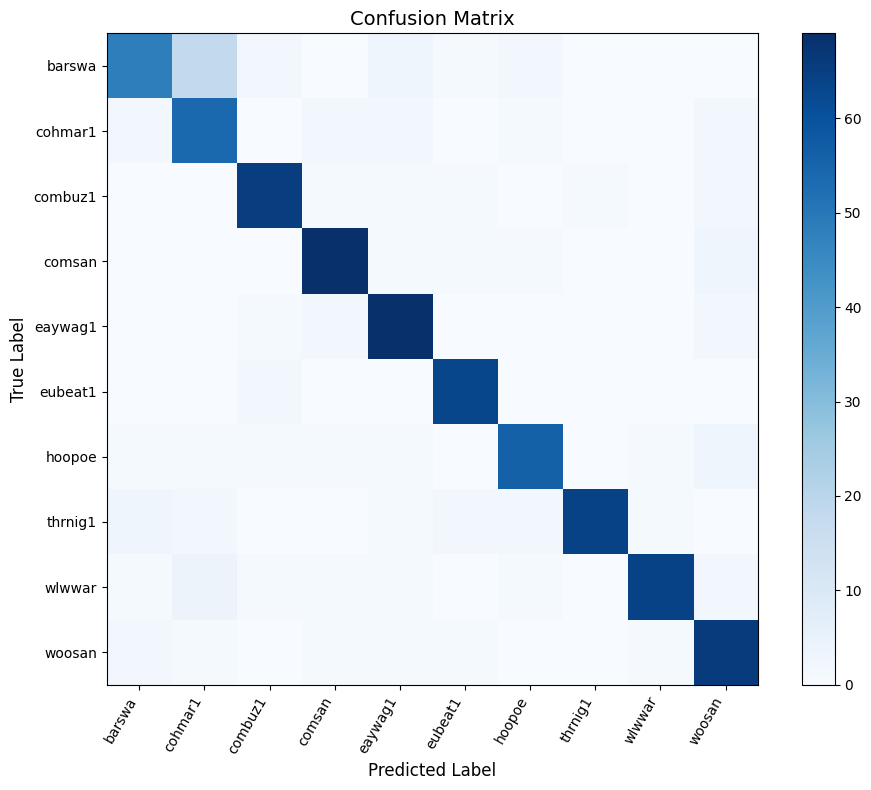

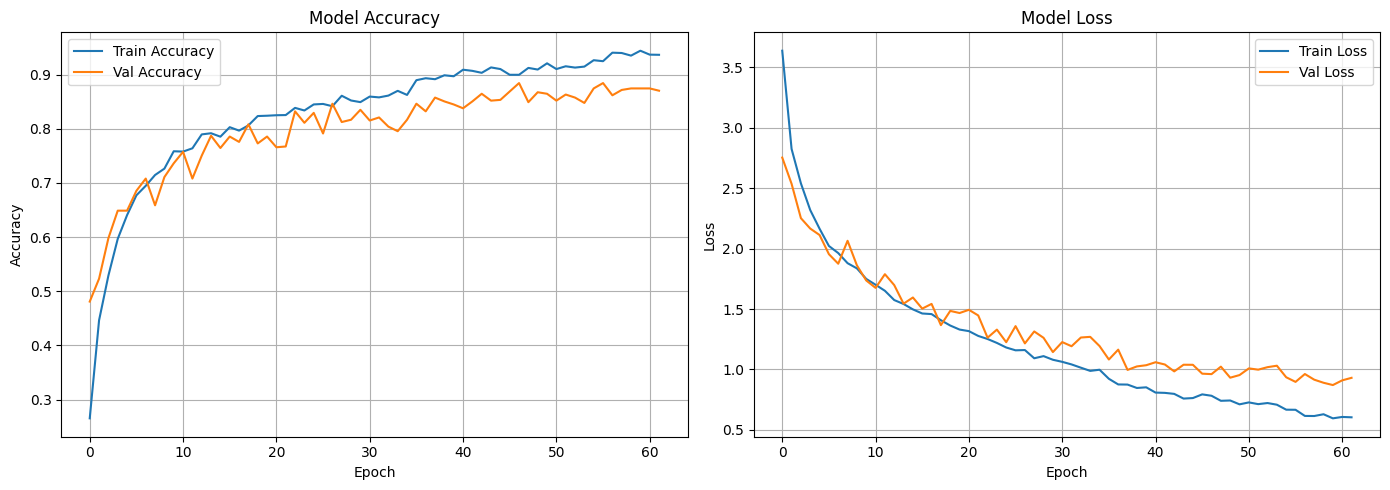


Model saved to: /drive/MyDrive/SYDE 577/BirdClef Models/best_1dcnn_improved.h5
Confusion matrix saved to Google Drive
Training history saved to Google Drive
Training complete!


In [7]:
"""
Improved 1D-CNN for BirdCLEF 2024 with Data Augmentation
FIXED VERSION - No learning rate schedule conflicts
Optimized for GPU training on Google Colab
"""

import os
import pickle
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# ==================== GPU SETUP ====================
print("="*60)
print("GPU Configuration")
print("="*60)

# Check GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Enable memory growth to avoid OOM errors
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✓ Found {len(gpus)} GPU(s)")
        print(f"  GPU Name: {gpus[0].name}")

        # Set mixed precision for faster training
        from tensorflow.keras import mixed_precision
        policy = mixed_precision.Policy('mixed_float16')
        mixed_precision.set_global_policy(policy)
        print("✓ Mixed precision enabled (float16)")

    except RuntimeError as e:
        print(f"GPU setup error: {e}")
else:
    print("⚠ No GPU found - training will be slow!")
    print("  Enable GPU: Runtime → Change runtime type → GPU")

print("="*60 + "\n")

# ----------------------- CONFIG -----------------------
PKL_PATH = 'drive/MyDrive/SYDE 577/BirdClef Models/data/features_mfcc_chroma.pkl'
MAX_LEN = 938
BATCH_SIZE = 64  # Increased for GPU
EPOCHS = 100
RANDOM_STATE = 42
MODEL_SAVE = "/drive/MyDrive/SYDE 577/BirdClef Models/best_1dcnn_improved.h5"
# ------------------------------------------------------

# ==================== DATA AUGMENTATION ====================
class AudioAugmenter:
    def __init__(self, time_mask_prob=0.3, freq_mask_prob=0.3,
                 noise_prob=0.2, shift_prob=0.3):
        self.time_mask_prob = time_mask_prob
        self.freq_mask_prob = freq_mask_prob
        self.noise_prob = noise_prob
        self.shift_prob = shift_prob

    def time_mask(self, x, mask_size=20):
        x = x.copy()
        t = x.shape[0]
        if t <= mask_size:
            return x
        t0 = np.random.randint(0, t - mask_size)
        x[t0:t0+mask_size, :] = 0
        return x

    def freq_mask(self, x, mask_size=5):
        x = x.copy()
        f = x.shape[1]
        if f <= mask_size:
            return x
        f0 = np.random.randint(0, f - mask_size)
        x[:, f0:f0+mask_size] = 0
        return x

    def add_noise(self, x, noise_factor=0.005):
        noise = np.random.randn(*x.shape) * noise_factor
        return x + noise

    def time_shift(self, x, shift_max=50):
        shift = np.random.randint(-shift_max, shift_max)
        return np.roll(x, shift, axis=0)

    def augment(self, x):
        if np.random.rand() < self.time_mask_prob:
            x = self.time_mask(x)
        if np.random.rand() < self.freq_mask_prob:
            x = self.freq_mask(x)
        if np.random.rand() < self.noise_prob:
            x = self.add_noise(x)
        if np.random.rand() < self.shift_prob:
            x = self.time_shift(x)
        return x


class AugmentedGenerator(tf.keras.utils.Sequence):
    def __init__(self, X, y, batch_size, augmenter=None, shuffle=True):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.augmenter = augmenter
        self.shuffle = shuffle
        self.indices = np.arange(len(X))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        X_batch = self.X[batch_indices].copy()
        y_batch = self.y[batch_indices]

        if self.augmenter is not None:
            for i in range(len(X_batch)):
                X_batch[i] = self.augmenter.augment(X_batch[i])

        return X_batch, y_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# ==================== LOAD DATA ====================
print("Loading data...")
with open(PKL_PATH, "rb") as f:
    cache = pickle.load(f)

X_raw = cache["X"]
y_raw = np.array(cache["y"])

print(f"Loaded: {PKL_PATH}")
print(f"Raw X length: {len(X_raw)}, Raw y length: {len(y_raw)}")

# Filter out None entries
valid_idx = [i for i, x in enumerate(X_raw) if x is not None]
if len(valid_idx) != len(X_raw):
    print(f"Filtering out {len(X_raw)-len(valid_idx)} failed extractions.")
    X_raw = [X_raw[i] for i in valid_idx]
    y_raw = y_raw[valid_idx]

print(f"Valid samples: {len(X_raw)}")
print(f"Feature dimension: {X_raw[0].shape[1]}")

# ==================== PREPROCESSING ====================
def pad_to_maxlen(X_list, max_len, feat_dim):
    N = len(X_list)
    out = np.zeros((N, max_len, feat_dim), dtype=np.float32)
    for i, arr in enumerate(X_list):
        L = min(len(arr), max_len)
        out[i, :L, :] = arr[:L, :]
    return out

feat_dim = X_raw[0].shape[1]
X_padded = pad_to_maxlen(X_raw, MAX_LEN, feat_dim)
print(f"X_padded shape: {X_padded.shape}")

# Label encoding
le = LabelEncoder()
y = le.fit_transform(y_raw)
num_classes = len(le.classes_)
print(f"Number of classes: {num_classes}")
print(f"Classes: {le.classes_}")

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(
    X_padded, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=RANDOM_STATE, stratify=y_temp
)
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# Normalize using training statistics
train_flat = X_train.reshape(-1, feat_dim)
mu = train_flat.mean(axis=0)
sigma = train_flat.std(axis=0) + 1e-9

X_train = (X_train - mu.reshape(1, 1, -1)) / sigma.reshape(1, 1, -1)
X_val = (X_val - mu.reshape(1, 1, -1)) / sigma.reshape(1, 1, -1)
X_test = (X_test - mu.reshape(1, 1, -1)) / sigma.reshape(1, 1, -1)

# ==================== MODEL ====================
def build_improved_1dcnn(input_shape, num_classes, lr=1e-3, l2=0.001):
    """
    FIXED: Removed ExponentialDecay to work with ReduceLROnPlateau
    """
    tf.keras.backend.clear_session()
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Block 1
    x = tf.keras.layers.Conv1D(64, kernel_size=7, padding="same",
                               kernel_regularizer=tf.keras.regularizers.l2(l2))(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    # Block 2
    x = tf.keras.layers.Conv1D(128, kernel_size=5, padding="same",
                               kernel_regularizer=tf.keras.regularizers.l2(l2))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    # Block 3
    x = tf.keras.layers.Conv1D(256, kernel_size=3, padding="same",
                               kernel_regularizer=tf.keras.regularizers.l2(l2))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    # Block 4
    x = tf.keras.layers.Conv1D(256, kernel_size=3, padding="same",
                               kernel_regularizer=tf.keras.regularizers.l2(l2))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.GlobalMaxPooling1D()(x)

    # Dense layers
    x = tf.keras.layers.Dense(512, activation="relu",
                             kernel_regularizer=tf.keras.regularizers.l2(l2))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Dense(256, activation="relu",
                             kernel_regularizer=tf.keras.regularizers.l2(l2))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs)

    # FIXED: Simple Adam optimizer (no schedule) to work with ReduceLROnPlateau
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=["accuracy"]
    )
    return model

print("\nBuilding model...")
model = build_improved_1dcnn((MAX_LEN, feat_dim), num_classes, lr=1e-3, l2=0.001)
model.summary()

# ==================== TRAINING ====================
# Callbacks
callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1),
    ModelCheckpoint(MODEL_SAVE, monitor="val_accuracy", save_best_only=True, verbose=1)
]

# Class weights for imbalance
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weights = {i: w for i, w in enumerate(class_weights)}
print(f"\nClass weights computed: {len(class_weights)} classes")

# Data generators with augmentation
augmenter = AudioAugmenter()
train_gen = AugmentedGenerator(X_train, y_train, BATCH_SIZE, augmenter=augmenter)
val_gen = AugmentedGenerator(X_val, y_val, BATCH_SIZE, augmenter=None, shuffle=False)

print("\nStarting training...")
print(f"Training on: {tf.config.list_physical_devices('GPU')[0].name if gpus else 'CPU'}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Steps per epoch: {len(train_gen)}")
print("="*60 + "\n")

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

# ==================== EVALUATION ====================
print("\n" + "="*60)
print("Evaluating on test set...")
results = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f} ({results[1]*100:.2f}%)")

# Predictions
y_prob = model.predict(X_test, batch_size=BATCH_SIZE, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix", fontsize=14)
plt.colorbar()
tick_marks = np.arange(len(le.classes_))
plt.xticks(tick_marks, le.classes_, rotation=60, ha='right')
plt.yticks(tick_marks, le.classes_)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.savefig('/drive/MyDrive/SYDE 577/BirdClef Models/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Training history plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Val Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Val Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/SYDE 577/BirdClef Models/training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print(f"Model saved to: {MODEL_SAVE}")
print(f"Confusion matrix saved to Google Drive")
print(f"Training history saved to Google Drive")
print("Training complete!")
print("="*60)

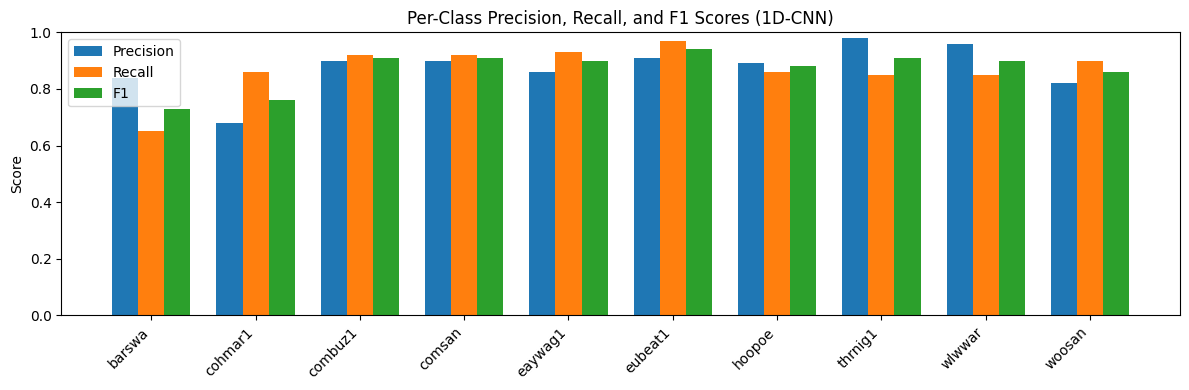

In [14]:
import numpy as np
import matplotlib.pyplot as plt

classes = ["barswa","cohmar1","combuz1","comsan","eaywag1",
           "eubeat1","hoopoe","thrnig1","wlwwar","woosan"]

precision = [0.84, 0.68, 0.90, 0.90, 0.86, 0.91, 0.89, 0.98, 0.96, 0.82]
recall    = [0.65, 0.86, 0.92, 0.92, 0.93, 0.97, 0.86, 0.85, 0.85, 0.90]
f1        = [0.73, 0.76, 0.91, 0.91, 0.90, 0.94, 0.88, 0.91, 0.90, 0.86]

x = np.arange(len(classes))
width = 0.25

plt.figure(figsize=(12,4))
plt.bar(x - width, precision, width, label='Precision')
plt.bar(x,         recall,    width, label='Recall')
plt.bar(x + width, f1,        width, label='F1')

plt.xticks(x, classes, rotation=45, ha='right')
plt.ylim(0,1)
plt.ylabel("Score")
plt.title("Per-Class Precision, Recall, and F1 Scores (1D-CNN)")
plt.legend()
plt.tight_layout()
plt.show()


In [16]:
print("\nTraining model WITHOUT data augmentation...")

model_no_aug = build_improved_1dcnn(
    input_shape=(MAX_LEN, feat_dim),
    num_classes=num_classes,
    lr=1e-3,
    l2=0.001
)

history_no_aug = model_no_aug.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[
        EarlyStopping(monitor="val_accuracy", patience=15, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1),
        ModelCheckpoint("model_no_aug.h5", monitor="val_accuracy", save_best_only=True, verbose=1)
    ],
    class_weight=class_weights,
    verbose=1
)



Training model WITHOUT data augmentation...
Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.1378 - loss: 4.2677
Epoch 1: val_accuracy improved from -inf to 0.27786, saving model to model_no_aug.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 26s 250ms/step - accuracy: 0.1385 - loss: 4.2625 - val_accuracy: 0.2779 - val_loss: 3.3327 - learning_rate: 0.0010
Epoch 2/100
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3030 - loss: 3.3744
Epoch 2: val_accuracy improved from 0.27786 to 0.45557, saving model to model_no_aug.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.3039 - loss: 3.3660 - val_accuracy: 0.4556 - val_loss: 2.7142 - learning_rate: 0.0010
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4050 - loss: 2.8858
Epoch 3: val_accuracy improved from 0.45557 to 0.54302, saving model to model_no_aug.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.4054 - loss: 2.8849 - val_accuracy: 0.5430 - val_loss: 2.5248 - learning_rate: 0.0010
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5132 - loss: 2.5835
Epoch 4: val_accuracy improved from 0.54302 to 0.57687, saving model to model_no_aug.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5135 - loss: 2.5823 - val_accuracy: 0.5769 - val_loss: 2.3920 - learning_rate: 0.0010
Epoch 5/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5831 - loss: 2.3637
Epoch 5: val_accuracy improved from 0.57687 to 0.60508, saving model to model_no_aug.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5836 - loss: 2.3615 - val_accuracy: 0.6051 - val_loss: 2.2078 - learning_rate: 0.0010
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6114 - loss: 2.2266
Epoch 6: val_accuracy did not improve from 0.60508
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6118 - loss: 2.2258 - val_accuracy: 0.5797 - val_loss: 2.2260 - learning_rate: 0.0010
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6713 - loss: 2.0030
Epoch 7: val_accuracy did not improve from 0.60508
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6713 - loss: 2.0035 - val_accuracy: 0.5769 - val_loss: 2.1757 - learning_rate: 0.0010
Epoch 8/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6875 - loss: 1.9698
Epoch 8: val_accuracy improved from 0.60508 to 0.64457, saving model to model_no_aug.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6879 - loss: 1.9691 - val_accuracy: 0.6446 - val_loss: 1.9795 - learning_rate: 0.0010
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7121 - loss: 1.8567
Epoch 9: val_accuracy improved from 0.64457 to 0.67983, saving model to model_no_aug.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7120 - loss: 1.8567 - val_accuracy: 0.6798 - val_loss: 1.8835 - learning_rate: 0.0010
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7282 - loss: 1.7885
Epoch 10: val_accuracy improved from 0.67983 to 0.68124, saving model to model_no_aug.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7283 - loss: 1.7882 - val_accuracy: 0.6812 - val_loss: 1.8954 - learning_rate: 0.0010
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7644 - loss: 1.6744
Epoch 11: val_accuracy did not improve from 0.68124
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7642 - loss: 1.6751 - val_accuracy: 0.6685 - val_loss: 1.9085 - learning_rate: 0.0010
Epoch 12/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7315 - loss: 1.7163
Epoch 12: val_accuracy improved from 0.68124 to 0.69535, saving model to model_no_aug.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7320 - loss: 1.7154 - val_accuracy: 0.6953 - val_loss: 1.7896 - learning_rate: 0.0010
Epoch 13/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7674 - loss: 1.6196
Epoch 13: val_accuracy did not improve from 0.69535
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7674 - loss: 1.6197 - val_accuracy: 0.6897 - val_loss: 1.7816 - learning_rate: 0.0010
Epoch 14/100
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7752 - loss: 1.5568
Epoch 14: val_accuracy improved from 0.69535 to 0.75882, saving model to model_no_aug.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.7750 - loss: 1.5577 - val_accuracy: 0.7588 - val_loss: 1.6316 - learning_rate: 0.0010
Epoch 15/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7903 - loss: 1.4874
Epoch 15: val_accuracy did not improve from 0.75882
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7902 - loss: 1.4877 - val_accuracy: 0.7207 - val_loss: 1.6521 - learning_rate: 0.0010
Epoch 16/100
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8045 - loss: 1.4468
Epoch 16: val_accuracy did not improve from 0.75882
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8042 - loss: 1.4468 - val_accuracy: 0.7546 - val_loss: 1.5354 - learning_rate: 0.0010
Epoch 17/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8059 - loss: 1.4056
Epoch 17: val_accuracy did not improve from 0.75882
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.8058 - loss: 1.4061 - val_accuracy: 0.7560 - val_loss: 1.5587 - learning_rate: 0.0010
Epoch 18/100
51/52 ━━━━

52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8141 - loss: 1.3728 - val_accuracy: 0.7913 - val_loss: 1.4117 - learning_rate: 0.0010
Epoch 20/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8121 - loss: 1.3028
Epoch 20: val_accuracy did not improve from 0.79126
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8122 - loss: 1.3028 - val_accuracy: 0.7179 - val_loss: 1.6412 - learning_rate: 0.0010
Epoch 21/100
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8209 - loss: 1.3180
Epoch 21: val_accuracy did not improve from 0.79126
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8213 - loss: 1.3163 - val_accuracy: 0.7842 - val_loss: 1.3828 - learning_rate: 0.0010
Epoch 22/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8350 - loss: 1.2380
Epoch 22: val_accuracy improved from 0.79126 to 0.80395, saving model to model_no_aug.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8351 - loss: 1.2379 - val_accuracy: 0.8039 - val_loss: 1.3541 - learning_rate: 0.0010
Epoch 23/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8467 - loss: 1.1954
Epoch 23: val_accuracy did not improve from 0.80395
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8466 - loss: 1.1958 - val_accuracy: 0.7983 - val_loss: 1.3610 - learning_rate: 0.0010
Epoch 24/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8462 - loss: 1.1621
Epoch 24: val_accuracy did not improve from 0.80395
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8462 - loss: 1.1619 - val_accuracy: 0.7546 - val_loss: 1.4166 - learning_rate: 0.0010
Epoch 25/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8527 - loss: 1.1305
Epoch 25: val_accuracy did not improve from 0.80395
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8525 - loss: 1.1308 - val_accuracy: 0.7870 - val_loss: 1.4021 - learning_rate: 0.0010
Epoch 26/100
52/52 ━━━━

52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8945 - loss: 0.9829 - val_accuracy: 0.8209 - val_loss: 1.1811 - learning_rate: 5.0000e-04
Epoch 30/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8971 - loss: 0.9582
Epoch 30: val_accuracy did not improve from 0.82087
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8971 - loss: 0.9583 - val_accuracy: 0.8138 - val_loss: 1.2118 - learning_rate: 5.0000e-04
Epoch 31/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9047 - loss: 0.9397
Epoch 31: val_accuracy did not improve from 0.82087
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9047 - loss: 0.9398 - val_accuracy: 0.7814 - val_loss: 1.3082 - learning_rate: 5.0000e-04
Epoch 32/100
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9001 - loss: 0.9419
Epoch 32: val_accuracy improved from 0.82087 to 0.82511, saving model to model_no_aug.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8999 - loss: 0.9413 - val_accuracy: 0.8251 - val_loss: 1.1261 - learning_rate: 5.0000e-04
Epoch 33/100
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9039 - loss: 0.9207
Epoch 33: val_accuracy improved from 0.82511 to 0.82934, saving model to model_no_aug.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9035 - loss: 0.9211 - val_accuracy: 0.8293 - val_loss: 1.1298 - learning_rate: 5.0000e-04
Epoch 34/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8979 - loss: 0.8940
Epoch 34: val_accuracy did not improve from 0.82934
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8978 - loss: 0.8943 - val_accuracy: 0.8279 - val_loss: 1.1117 - learning_rate: 5.0000e-04
Epoch 35/100
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9015 - loss: 0.8675
Epoch 35: val_accuracy did not improve from 0.82934
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9016 - loss: 0.8679 - val_accuracy: 0.8195 - val_loss: 1.1777 - learning_rate: 5.0000e-04
Epoch 36/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9236 - loss: 0.8174
Epoch 36: val_accuracy improved from 0.82934 to 0.85190, saving model to model_no_aug.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9233 - loss: 0.8182 - val_accuracy: 0.8519 - val_loss: 1.0803 - learning_rate: 5.0000e-04
Epoch 37/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9134 - loss: 0.8239
Epoch 37: val_accuracy did not improve from 0.85190
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9133 - loss: 0.8241 - val_accuracy: 0.8350 - val_loss: 1.0990 - learning_rate: 5.0000e-04
Epoch 38/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9138 - loss: 0.8251
Epoch 38: val_accuracy did not improve from 0.85190
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9138 - loss: 0.8253 - val_accuracy: 0.8519 - val_loss: 1.0782 - learning_rate: 5.0000e-04
Epoch 39/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9188 - loss: 0.8081
Epoch 39: val_accuracy did not improve from 0.85190
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9186 - loss: 0.8088 - val_accuracy: 0.8392 - val_loss: 1.0833 - learning_rate: 5.0000e-04
Epoch 4

52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9418 - loss: 0.7099 - val_accuracy: 0.8590 - val_loss: 1.0099 - learning_rate: 2.5000e-04
Epoch 46/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9376 - loss: 0.6934
Epoch 46: val_accuracy did not improve from 0.85896
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9376 - loss: 0.6933 - val_accuracy: 0.8547 - val_loss: 1.0398 - learning_rate: 2.5000e-04
Epoch 47/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9444 - loss: 0.6700
Epoch 47: val_accuracy did not improve from 0.85896
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9443 - loss: 0.6701 - val_accuracy: 0.8491 - val_loss: 1.0660 - learning_rate: 2.5000e-04
Epoch 48/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9463 - loss: 0.6654
Epoch 48: val_accuracy did not improve from 0.85896
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9462 - loss: 0.6656 - val_accuracy: 0.8561 - val_loss: 1.0182 - learning_rate: 2.5000e-04
Epoch 4

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9507 - loss: 0.6311 - val_accuracy: 0.8632 - val_loss: 1.0100 - learning_rate: 1.2500e-04
Epoch 52/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9542 - loss: 0.6202
Epoch 52: val_accuracy did not improve from 0.86319
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9542 - loss: 0.6202 - val_accuracy: 0.8590 - val_loss: 1.0009 - learning_rate: 1.2500e-04
Epoch 53/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9676 - loss: 0.5854
Epoch 53: val_accuracy improved from 0.86319 to 0.86460, saving model to model_no_aug.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9675 - loss: 0.5856 - val_accuracy: 0.8646 - val_loss: 0.9971 - learning_rate: 1.2500e-04
Epoch 54/100
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9611 - loss: 0.5937
Epoch 54: val_accuracy did not improve from 0.86460
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9611 - loss: 0.5933 - val_accuracy: 0.8618 - val_loss: 1.0179 - learning_rate: 1.2500e-04
Epoch 55/100
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9568 - loss: 0.6140
Epoch 55: val_accuracy did not improve from 0.86460
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9570 - loss: 0.6134 - val_accuracy: 0.8632 - val_loss: 0.9935 - learning_rate: 1.2500e-04
Epoch 56/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9639 - loss: 0.5830
Epoch 56: val_accuracy improved from 0.86460 to 0.87024, saving model to model_no_aug.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9639 - loss: 0.5830 - val_accuracy: 0.8702 - val_loss: 0.9806 - learning_rate: 1.2500e-04
Epoch 57/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9657 - loss: 0.5691
Epoch 57: val_accuracy did not improve from 0.87024
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9655 - loss: 0.5694 - val_accuracy: 0.8660 - val_loss: 0.9993 - learning_rate: 1.2500e-04
Epoch 58/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9635 - loss: 0.5907
Epoch 58: val_accuracy did not improve from 0.87024
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9636 - loss: 0.5903 - val_accuracy: 0.8688 - val_loss: 0.9761 - learning_rate: 1.2500e-04
Epoch 59/100
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9661 - loss: 0.5748
Epoch 59: val_accuracy improved from 0.87024 to 0.88011, saving model to model_no_aug.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9658 - loss: 0.5753 - val_accuracy: 0.8801 - val_loss: 0.9757 - learning_rate: 1.2500e-04
Epoch 60/100
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9689 - loss: 0.5616
Epoch 60: val_accuracy did not improve from 0.88011
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9688 - loss: 0.5616 - val_accuracy: 0.8702 - val_loss: 0.9706 - learning_rate: 1.2500e-04
Epoch 61/100
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9704 - loss: 0.5616
Epoch 61: val_accuracy did not improve from 0.88011
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9703 - loss: 0.5619 - val_accuracy: 0.8717 - val_loss: 0.9754 - learning_rate: 1.2500e-04
Epoch 62/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9687 - loss: 0.5470
Epoch 62: val_accuracy did not improve from 0.88011
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9687 - loss: 0.5471 - val_accuracy: 0.8674 - val_loss: 0.9873 - learning_rate: 1.2500e-04
Epoch 6


Evaluating on test set...
Test Loss: 0.9628
Test Accuracy: 0.8479 (84.79%)

Classification Report:
              precision    recall  f1-score   support

      barswa       0.66      0.70      0.68        74
     cohmar1       0.81      0.56      0.66        63
     combuz1       0.91      0.89      0.90        71
      comsan       0.84      0.93      0.89        75
     eaywag1       0.93      0.88      0.90        74
     eubeat1       0.88      0.98      0.93        65
      hoopoe       0.89      0.86      0.88        65
     thrnig1       0.94      0.88      0.91        75
      wlwwar       0.84      0.91      0.87        75
      woosan       0.80      0.86      0.83        73

    accuracy                           0.85       710
   macro avg       0.85      0.85      0.84       710
weighted avg       0.85      0.85      0.85       710



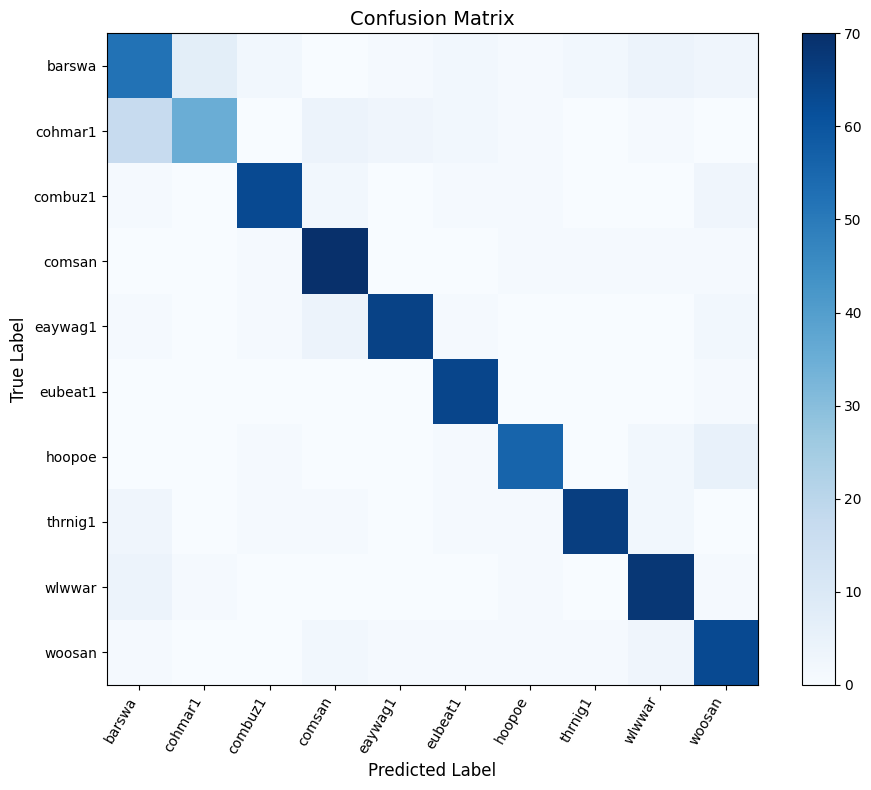

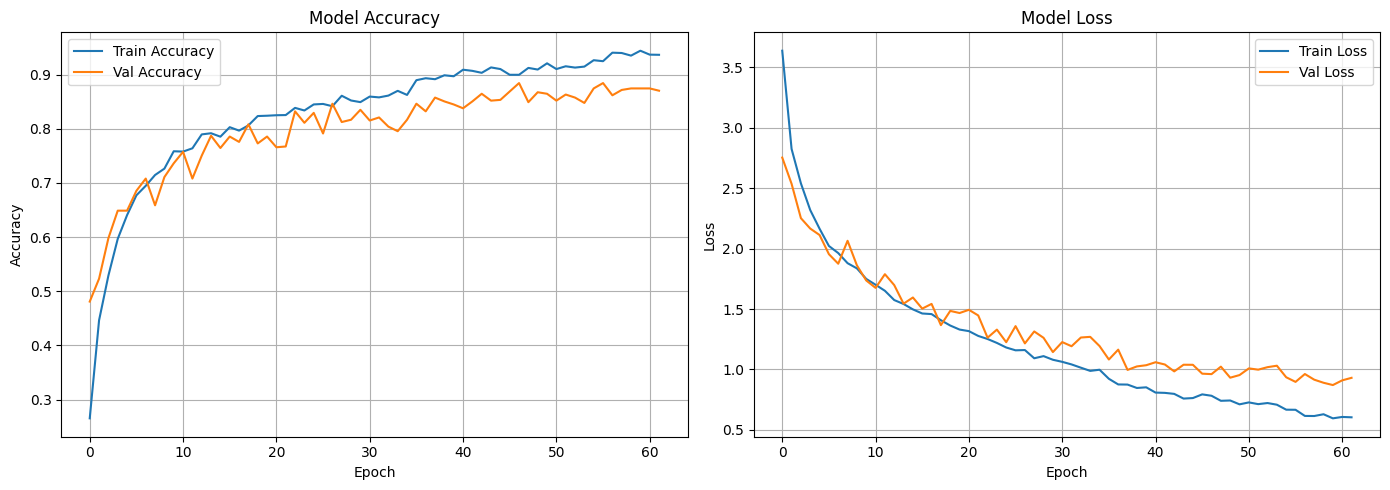


Model saved to: /drive/MyDrive/SYDE 577/BirdClef Models/best_1dcnn_improved.h5
Confusion matrix saved to Google Drive
Training history saved to Google Drive
Training complete!


In [17]:
# Choose which model to evaluate:
model_to_eval = model_no_aug       # <- change to model if you want augmented model
history_to_plot = history_no_aug   # <- change to history if using augmented model
# ==================== EVALUATION ====================
print("\n" + "="*60)
print("Evaluating on test set...")

results = model_to_eval.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f} ({results[1]*100:.2f}%)")

# Predictions
y_prob = model_to_eval.predict(X_test, batch_size=BATCH_SIZE, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix", fontsize=14)
plt.colorbar()
tick_marks = np.arange(len(le.classes_))
plt.xticks(tick_marks, le.classes_, rotation=60, ha='right')
plt.yticks(tick_marks, le.classes_)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/SYDE 577/BirdClef Models/confusion_matrix_no_aug.png',
            dpi=300, bbox_inches='tight')
plt.show()

# Training history plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history_to_plot.history['accuracy'], label='Train Accuracy')
ax1.plot(history_to_plot.history['val_accuracy'], label='Val Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

ax2.plot(history_to_plot.history['loss'], label='Train Loss')
ax2.plot(history_to_plot.history['val_loss'], label='Val Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/SYDE 577/BirdClef Models/training_history_no_aug.png',
            dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("Evaluation complete!")
print("="*60)


## diagrams

Generating compact visualizations for your report...

1. Creating block diagram...


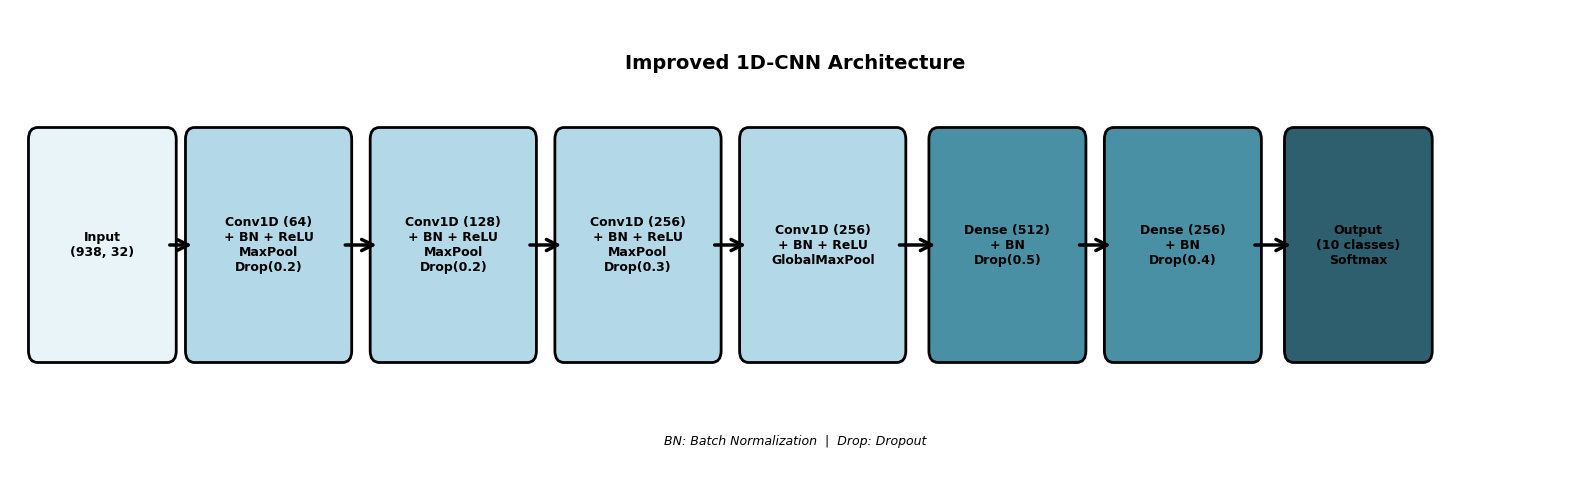

✓ Compact block diagram saved!

2. Creating comparison diagram...


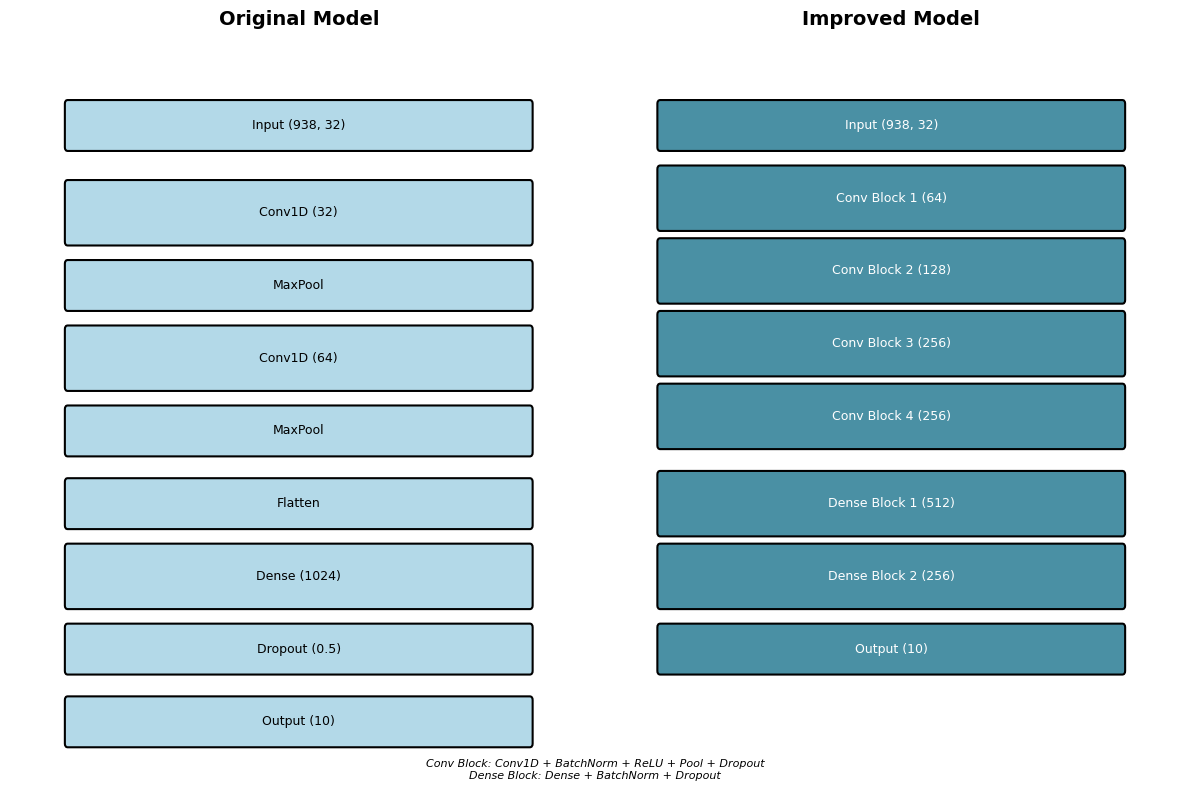

✓ Comparison diagram saved!

3. Creating architecture table...


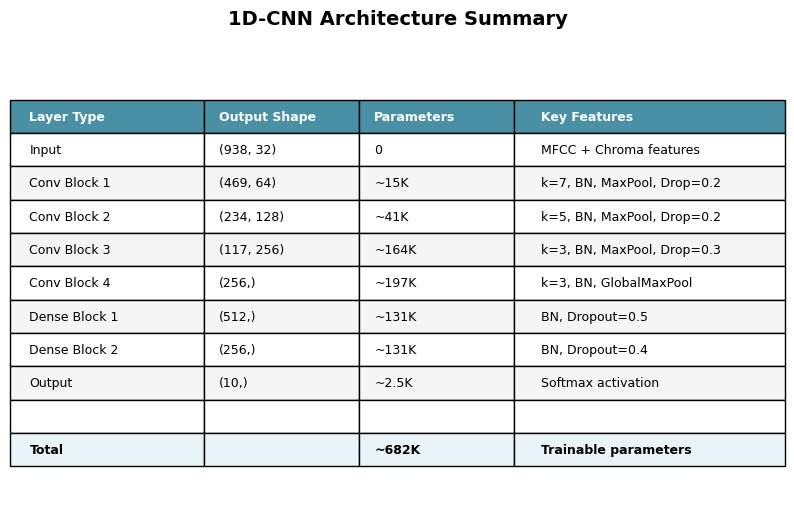

✓ Architecture table saved!

4. Creating minimal flowchart...


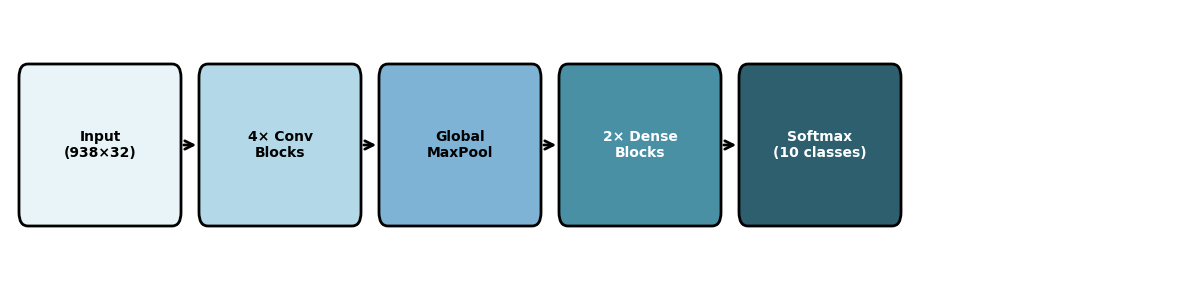

✓ Minimal flowchart saved!

All compact visualizations saved to Google Drive!

Recommendations for your report:
  • Use 'model_compact_blocks.png' for detailed view
  • Use 'model_minimal.png' for presentations/slides
  • Use 'model_comparison.png' to show improvements
  • Use 'model_table.png' for technical specifications


In [10]:
"""
Compact Model Architecture Visualization - Perfect for Reports
Creates clean, condensed diagrams suitable for academic papers/presentations
"""

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
import numpy as np

# ==================== METHOD 1: Block Diagram (Recommended) ====================
def create_compact_architecture_diagram():
    """
    Creates a clean horizontal block diagram showing major components only
    """
    fig, ax = plt.subplots(1, 1, figsize=(16, 5))
    ax.set_xlim(0, 17)
    ax.set_ylim(0, 4)
    ax.axis('off')

    # Define colors
    input_color = '#E8F4F8'
    conv_color = '#B3D9E8'
    pool_color = '#7FB3D5'
    dense_color = '#4A90A4'
    output_color = '#2E5F6F'

    blocks = [
        # (x_pos, label, color, width)
        (1, 'Input\n(938, 32)', input_color, 1.4),
        (2.8, 'Conv1D (64)\n+ BN + ReLU\nMaxPool\nDrop(0.2)', conv_color, 1.6),
        (4.8, 'Conv1D (128)\n+ BN + ReLU\nMaxPool\nDrop(0.2)', conv_color, 1.6),
        (6.8, 'Conv1D (256)\n+ BN + ReLU\nMaxPool\nDrop(0.3)', conv_color, 1.6),
        (8.8, 'Conv1D (256)\n+ BN + ReLU\nGlobalMaxPool', conv_color, 1.6),
        (10.8, 'Dense (512)\n+ BN\nDrop(0.5)', dense_color, 1.5),
        (12.7, 'Dense (256)\n+ BN\nDrop(0.4)', dense_color, 1.5),
        (14.6, 'Output\n(10 classes)\nSoftmax', output_color, 1.4),
    ]

    # Draw blocks
    y_center = 2
    box_height = 1.8

    for x_pos, label, color, width in blocks:
        box = FancyBboxPatch((x_pos - width/2, y_center - box_height/2), width, box_height,
                             boxstyle="round,pad=0.1",
                             edgecolor='black', facecolor=color,
                             linewidth=2)
        ax.add_patch(box)
        ax.text(x_pos, y_center, label, ha='center', va='center',
                fontsize=9, fontweight='bold')

    # Draw arrows
    for i in range(len(blocks) - 1):
        x_start = blocks[i][0] + blocks[i][3]/2
        x_end = blocks[i+1][0] - blocks[i+1][3]/2
        arrow = FancyArrowPatch((x_start, y_center), (x_end, y_center),
                               arrowstyle='->', mutation_scale=20,
                               linewidth=2.5, color='black')
        ax.add_patch(arrow)

    # Add title
    ax.text(8.5, 3.5, 'Improved 1D-CNN Architecture',
            ha='center', fontsize=14, fontweight='bold')

    # Add legend for abbreviations
    legend_text = "BN: Batch Normalization  |  Drop: Dropout"
    ax.text(8.5, 0.3, legend_text, ha='center', fontsize=9, style='italic')

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/SYDE 577/BirdClef Models/model_compact_blocks.png',
                dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    print("✓ Compact block diagram saved!")

# ==================== METHOD 2: Side-by-Side Comparison ====================
def create_comparison_diagram():
    """
    Side-by-side comparison of Original vs Improved
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

    # Original Model
    ax1.set_xlim(0, 10)
    ax1.set_ylim(0, 10)
    ax1.axis('off')
    ax1.set_title('Original Model', fontsize=14, fontweight='bold', pad=20)

    original_blocks = [
        (9, 'Input (938, 32)', 0.6),
        (7.8, 'Conv1D (32)', 0.8),
        (6.8, 'MaxPool', 0.6),
        (5.8, 'Conv1D (64)', 0.8),
        (4.8, 'MaxPool', 0.6),
        (3.8, 'Flatten', 0.6),
        (2.8, 'Dense (1024)', 0.8),
        (1.8, 'Dropout (0.5)', 0.6),
        (0.8, 'Output (10)', 0.6),
    ]

    for y, label, h in original_blocks:
        box = FancyBboxPatch((1, y-h/2), 8, h,
                             boxstyle="round,pad=0.05",
                             edgecolor='black', facecolor='#B3D9E8',
                             linewidth=1.5)
        ax1.add_patch(box)
        ax1.text(5, y, label, ha='center', va='center', fontsize=9)

    # Improved Model
    ax2.set_xlim(0, 10)
    ax2.set_ylim(0, 10)
    ax2.axis('off')
    ax2.set_title('Improved Model', fontsize=14, fontweight='bold', pad=20)

    improved_blocks = [
        (9, 'Input (938, 32)', 0.6),
        (8.0, 'Conv Block 1 (64)', 0.8),
        (7.0, 'Conv Block 2 (128)', 0.8),
        (6.0, 'Conv Block 3 (256)', 0.8),
        (5.0, 'Conv Block 4 (256)', 0.8),
        (3.8, 'Dense Block 1 (512)', 0.8),
        (2.8, 'Dense Block 2 (256)', 0.8),
        (1.8, 'Output (10)', 0.6),
    ]

    for y, label, h in improved_blocks:
        box = FancyBboxPatch((1, y-h/2), 8, h,
                             boxstyle="round,pad=0.05",
                             edgecolor='black', facecolor='#4A90A4',
                             linewidth=1.5)
        ax2.add_patch(box)
        ax2.text(5, y, label, ha='center', va='center', fontsize=9, color='white')

    # Add note
    note = "Conv Block: Conv1D + BatchNorm + ReLU + Pool + Dropout\nDense Block: Dense + BatchNorm + Dropout"
    fig.text(0.5, 0.02, note, ha='center', fontsize=8, style='italic')

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/SYDE 577/BirdClef Models/model_comparison.png',
                dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    print("✓ Comparison diagram saved!")

# ==================== METHOD 3: Summary Table ====================
def create_architecture_table():
    """
    Creates a clean table summarizing the architecture
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis('tight')
    ax.axis('off')

    # Table data
    table_data = [
        ['Layer Type', 'Output Shape', 'Parameters', 'Key Features'],
        ['Input', '(938, 32)', '0', 'MFCC + Chroma features'],
        ['Conv Block 1', '(469, 64)', '~15K', 'k=7, BN, MaxPool, Drop=0.2'],
        ['Conv Block 2', '(234, 128)', '~41K', 'k=5, BN, MaxPool, Drop=0.2'],
        ['Conv Block 3', '(117, 256)', '~164K', 'k=3, BN, MaxPool, Drop=0.3'],
        ['Conv Block 4', '(256,)', '~197K', 'k=3, BN, GlobalMaxPool'],
        ['Dense Block 1', '(512,)', '~131K', 'BN, Dropout=0.5'],
        ['Dense Block 2', '(256,)', '~131K', 'BN, Dropout=0.4'],
        ['Output', '(10,)', '~2.5K', 'Softmax activation'],
        ['', '', '', ''],
        ['Total', '', '~682K', 'Trainable parameters'],
    ]

    # Create table
    table = ax.table(cellText=table_data, cellLoc='left', loc='center',
                     colWidths=[0.25, 0.2, 0.2, 0.35])

    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)

    # Style header row
    for i in range(4):
        cell = table[(0, i)]
        cell.set_facecolor('#4A90A4')
        cell.set_text_props(weight='bold', color='white')

    # Style total row
    for i in range(4):
        cell = table[(10, i)]
        cell.set_facecolor('#E8F4F8')
        cell.set_text_props(weight='bold')

    # Alternate row colors
    for i in range(1, 10):
        for j in range(4):
            if i % 2 == 0:
                table[(i, j)].set_facecolor('#F5F5F5')

    plt.title('1D-CNN Architecture Summary', fontsize=14, fontweight='bold', pad=20)
    plt.savefig('/content/drive/MyDrive/SYDE 577/BirdClef Models/model_table.png',
                dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    print("✓ Architecture table saved!")

# ==================== METHOD 4: Minimal Flowchart ====================
def create_minimal_flowchart():
    """
    Ultra-compact flowchart for presentations
    """
    fig, ax = plt.subplots(figsize=(12, 3))
    ax.set_xlim(0, 13)
    ax.set_ylim(0, 2)
    ax.axis('off')

    blocks = [
        (0.5, 'Input\n(938×32)', '#E8F4F8'),
        (2, '4× Conv\nBlocks', '#B3D9E8'),
        (3.5, 'Global\nMaxPool', '#7FB3D5'),
        (5, '2× Dense\nBlocks', '#4A90A4'),
        (6.5, 'Softmax\n(10 classes)', '#2E5F6F'),
    ]

    x_positions = [1, 3, 5, 7, 9, 11]

    for i, (x_pos, (y, label, color)) in enumerate(zip(x_positions, blocks)):
        box = FancyBboxPatch((x_pos-0.8, 0.5), 1.6, 1,
                             boxstyle="round,pad=0.1",
                             edgecolor='black', facecolor=color,
                             linewidth=2)
        ax.add_patch(box)
        text_color = 'white' if i >= 3 else 'black'
        ax.text(x_pos, 1, label, ha='center', va='center',
                fontsize=10, fontweight='bold', color=text_color)

        # Draw arrow
        if i < len(blocks) - 1:
            arrow = FancyArrowPatch((x_pos+0.9, 1), (x_positions[i+1]-0.9, 1),
                                   arrowstyle='->', mutation_scale=15,
                                   linewidth=2, color='black')
            ax.add_patch(arrow)

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/SYDE 577/BirdClef Models/model_minimal.png',
                dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    print("✓ Minimal flowchart saved!")

# ==================== Run All Methods ====================
print("Generating compact visualizations for your report...\n")

print("1. Creating block diagram...")
create_compact_architecture_diagram()

print("\n2. Creating comparison diagram...")
create_comparison_diagram()

print("\n3. Creating architecture table...")
create_architecture_table()

print("\n4. Creating minimal flowchart...")
create_minimal_flowchart()

print("\n" + "="*60)
print("All compact visualizations saved to Google Drive!")
print("="*60)
print("\nRecommendations for your report:")
print("  • Use 'model_compact_blocks.png' for detailed view")
print("  • Use 'model_minimal.png' for presentations/slides")
print("  • Use 'model_comparison.png' to show improvements")
print("  • Use 'model_table.png' for technical specifications")

Generating compact visualizations for your report...

1. Creating block diagram...


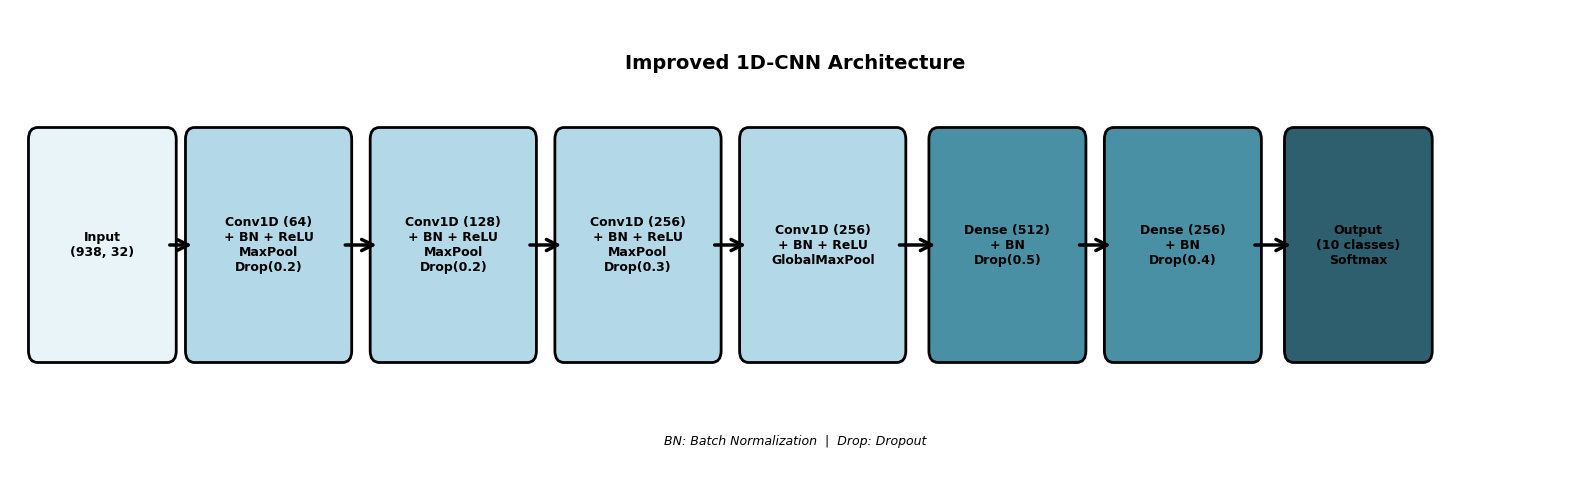

✓ Compact block diagram saved!

2. Creating comparison diagram...


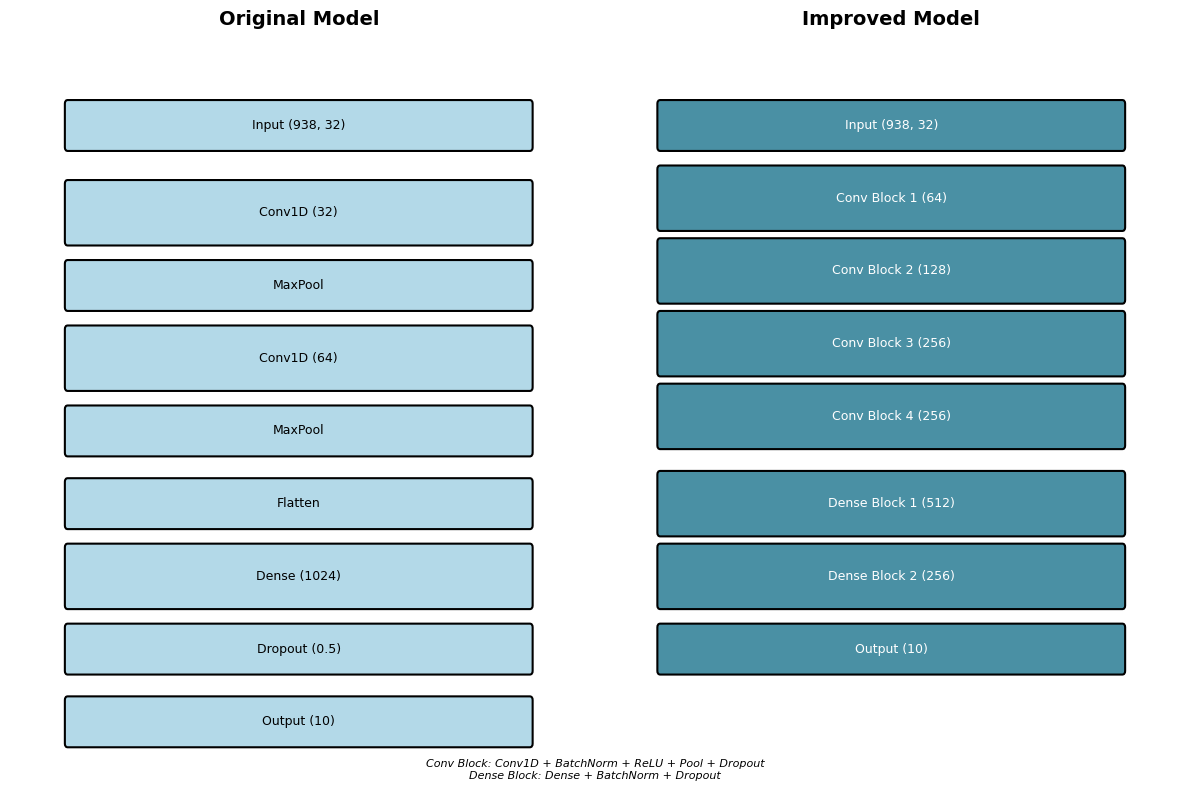

✓ Comparison diagram saved!

3. Creating architecture table...


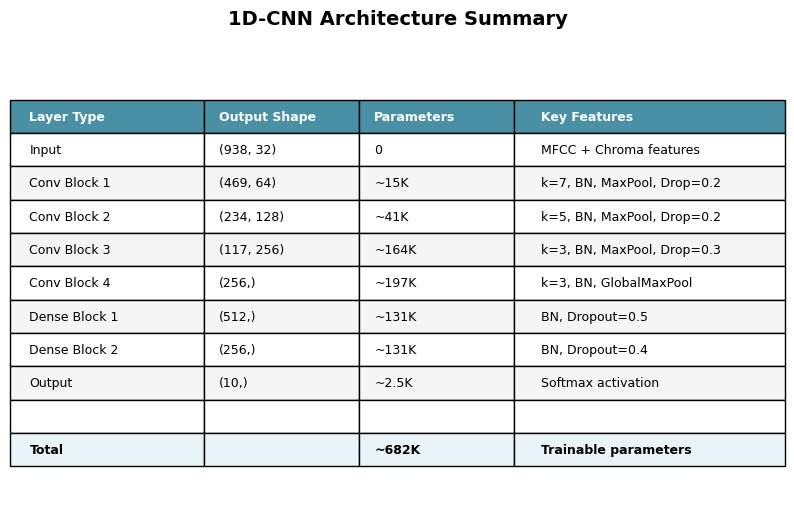

✓ Architecture table saved!

4. Creating minimal flowchart...


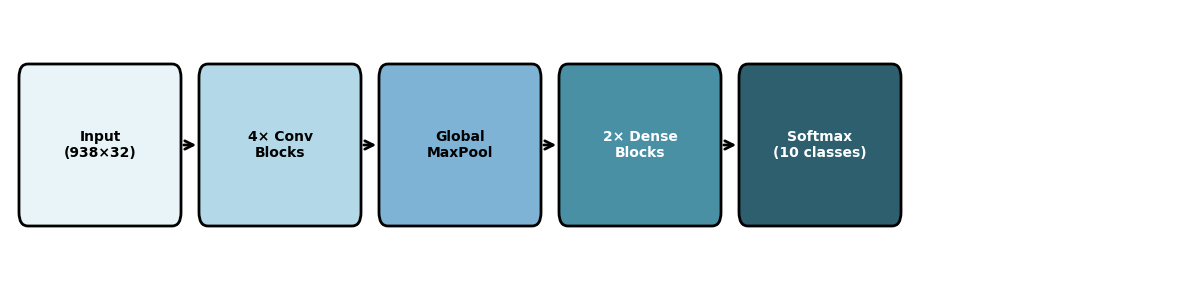

✓ Minimal flowchart saved!

All compact visualizations saved to Google Drive!

Recommendations for your report:
  • Use 'model_compact_blocks.png' for detailed view
  • Use 'model_minimal.png' for presentations/slides
  • Use 'model_comparison.png' to show improvements
  • Use 'model_table.png' for technical specifications
